# 🏡 Using Machine Learning to Guide InterState Relocations in Nigeria: Prediction and Recommendation Engine.

**Author**: Tosin Harold Akingbemisilu

Relocating from a State to another State within a country is not an easy task, most especially when trying to look for a new apartment, while considering your budget, location, proximity, etc. Normally, you would likely make a wrong decision if you do not have the right information to back it up. This was my experience relocating to Abuja, the capital city of Nigeria. Knowing exactly where to look for an apartment based on my budget and number of rooms I wanted was a bit difficult. Agents were not even helpful. It was also difficult getting something out of listing websites to aid my search as prices were all over the place. I therefore decided to embark on this project to help me tone down my search based on my criteria, which ended up very helpful in finding the perfect location to settle. I believe this can also help anyone trying to relocate within Nigeria.

This project would be in 3 parts:
1. **Web scraping and cleaning** of the data we will use from [Nigeria Property Centre website](https://nigeriapropertycentre.com/), one of the most popular property listing website in Nigeria.
2. **Exploratory analysis** of the data looking at the following (**NB: an interactive dashboard would be created on Tableau to help for further exploration and deep dive for all States in Nigeria**):
  - The most expensive State and City in terms of apartment rent in Nigeria.
  - Maximum, Minimum, Median and Average price of rent by States.
  - Average and Median Rental Price by number of bedroom (with a focus on 1, 2, 3 and 4 bedrooms) grouped by States
  - Median Rental Price grouped by Area, identifying the most expensive place/neighbourhood in Nigeria
  - Median Rental Price by number of bedroom (with a focus on 1, 2, 3 and 4 bedrooms) grouped by Area.
  - Does time of the year have an effect on apartment rental price in Nigerian States? If so, what is the best time of the year to relocate to a particular State in Nigeria?
3. **Predictive Modelling**
  - Using the features available, can we predict the price of an apartment with an optimal accuracy score?
  - Using the available features such as one's budget and State, make a recommendation on the best place to rent an apartment.

## 1. Scraping and Cleaning our Data for Analysis

As mentioned earlier, we will be scraping our data from [Nigeria Property Centre website](https://nigeriapropertycentre.com/). This is one of the leading property website in Nigeria with property listings for sale, rent and lease, offering Nigerian property seekers an easy way to find details of property in Nigeria like homes, houses, lands, shops, office spaces and other commercial property. 

In our project however, we would be collecting data for unfurnished flats/Apartments posted for rent, with the knowledge that, not many States have furnished apartments for rent in Nigeria. The oldest data in this category was posted on 8 August 2020, and the newest as at the time of commencing this project was 9 August 2022. We also have **570 pages (11,790 records)** to pull data from, based on our selection criteria. Here is the revised link after filtering: 
https://nigeriapropertycentre.com/for-rent/unfurnished/flats-apartments/showtype?page=1

### 1.1 Scraping the First Page

Firstly, we will try to scrape the first page, to test, setup our request and pull the data. Afterwards, we will use a while loop to read the content of the whole **590** pages. For the first attempt to get the information we would need, we will:  

- start by importing `requests` and `BeautifulSoup`. 
- use `requests` to send HTTP/1.1 requests using Python. With it, we can add content like headers, form data, multipart files, and parameters via simple Python libraries. It also allows us to access the response data of Python in the same way.
- use `BeautifulSoup` to pull data out of HTML and XML files.
- identify the classes used on the page for each element we want to pull. Inspect element would be used for this.

In [ ]:
# Import requests and BeautifulSoup
import requests
from bs4 import BeautifulSoup as bs

In [ ]:
# Used innocuous headers/agent because the request was timed out and asking for an agent. 
# Using following code we can fake the agent.
headers = {"User-Agent": "Mozilla/5.0 (X11; CrOS x86_64 12871.102.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.141 Safari/537.36"}
# Specify url and attach it to URL variable
URL = 'https://nigeriapropertycentre.com/for-rent/unfurnished/flats-apartments/showtype?page=1'

Now that we have successfully established the connection, we will go ahead to read the content of the website.

In [ ]:
# Read the website content
response = requests.get(URL, headers=headers)
content = response.content
soup = bs(content,"html.parser")

We have been able to successfully dump the content retrieved after accessing the website. The dumped content then will be passed to the BeautifulSoup function in order to get only the data with HTML/valid website tags that were used to develop the website.

In [ ]:
propertylist = soup.find_all("div",attrs={"class": "row property-list "})

Now that we have the data dumped into a variable `propertylist` which currently is not in a readable format, it is time to go ahead to format our scraped data.

We are interested in extracting the property's address, date, price, payment period, room details (number of bedroom, bathroom, toilet, parking space). In order to start looking for these details, we would need to find the HTML tags which store this information. We will be using the inspect on our chrome browser to view the tag that keeps the collection of properties and other tags which has other details.

In [ ]:
# Importing datetime to today() function to help us return the current date in the proper format of other dates, for the tags labeled as 'added today' from the website.
from datetime import date
today = date.today().strftime("%d %b %Y")

# Create a list 'list_property' to append our data from a 'dataframe' dictionary created to add our key and value from the pulled data
list_property =[]
for tr in propertylist:
    dataframe ={}
    dataframe["prop_add"] = (tr.find("address",attrs={"class": "voffset-bottom-10"})).text.replace(' \xa0', '')
    #dataframe["prop_state"] = dataframe["prop_add"].rsplit(',', 1)[1].strip()
    #dataframe["prop_city"] = dataframe["prop_add"].rsplit(',', 2)[1].strip()
    dataframe["prop_date"] = ((tr.find("span",attrs={"class": "added-on"})).text.replace(' \xa0', '').replace('Added ', '').replace('on ', '').replace('Today', str(today)))
    dataframe["prop_price_NGN"] = (tr.find("span",attrs={"class": "pull-sm-left"})).text.replace(' \xa0', '').replace('\n₦', '').replace(',', '').replace(' per annum ', '')
    dataframe["prop_pay_period"] = (tr.find("span",attrs={"class": "period"})).text.replace(' \xa0', '').strip()
    dataframe["prop_allroom"] = (tr.find("ul",attrs={"class": "aux-info"})).text.replace('\xa0', '').replace(' Save','').replace('Bedrooms','Bedroom')\
    .replace('Bathrooms','Bathroom').replace('Toilets','Toilet').replace('Parking Spaces','Parking Space').replace('Bedroom','Bedroom, ')\
    .replace('Bathroom','Bathroom, ').replace('Toilet','Toilet, ').replace('Parking Space','Parking Space')
    #dataframe["prop_bedroom"] = dataframe["prop_allroom"].split(',')[0].strip().split(' ')[0]
    #dataframe["prop_bathroom"] = dataframe["prop_allroom"].split(',')[1].strip().split(' ')[0]
    #dataframe["prop_toilet"] = dataframe["prop_allroom"].split(',')[2].strip().split(' ')[0]
    #dataframe["prop_parking"] = dataframe["prop_allroom"].split(',')[3].strip().split(' ')[0]
    list_property.append(dataframe)

# show the number of properties
print(f'The total lenght of properties pulled is: {len(list_property)}')

The total lenght of properties pulled is: 20


In [ ]:
# View the first 5 properties pulled 
list_property[:5]

[{'prop_add': 'Short Drive From Ojodu Berger, Magboro, Ogun',
  'prop_allroom': '1 Bedroom, 1 Bathroom, 2 Toilet, 9 Parking Space',
  'prop_date': '09 Aug 2022',
  'prop_pay_period': 'per annum',
  'prop_price_NGN': '300000'},
 {'prop_add': 'Puposola, New Oko-Oba, Agege, Lagos',
  'prop_allroom': '3 Bedroom, 3 Toilet, ',
  'prop_date': '04 Aug 2022',
  'prop_pay_period': 'per annum',
  'prop_price_NGN': '900000'},
 {'prop_add': 'Journalist Estate, Berger, Arepo, Ogun',
  'prop_allroom': '3 Bedroom, 3 Bathroom, 4 Toilet, 8 Parking Space',
  'prop_date': '09 Aug 2022',
  'prop_pay_period': 'per annum',
  'prop_price_NGN': '800000'},
 {'prop_add': 'Short Drive From Ojodu Berger, Berger, Arepo, Ogun',
  'prop_allroom': '2 Bedroom, 2 Bathroom, 3 Toilet, 7 Parking Space',
  'prop_date': '09 Aug 2022',
  'prop_pay_period': 'per annum',
  'prop_price_NGN': '650000'},
 {'prop_add': 'Short Drive From Magodo, Opic, Isheri North, Lagos',
  'prop_allroom': '2 Bedroom, 2 Bathroom, 3 Toilet, 6 Parkin

### 1.2 Scraping the Whole Site and loading to CSV

Great! Now that we have everything figured out for the first page, we will go ahead to pull out all the **590** pages. Here are the additional steps for this phase:

- We will go through all the steps we have already processed earlier to pull data from the first page, except that this time, we will use a while loop to search through each page on the site, by specifying the total steps or number of pages we want to loop through. In this case, we will be using `https://nigeriapropertycentre.com/for-rent/unfurnished/flats-apartments/showtype?page=` without the number, but we will specify the first number as 1 and assign it to a variable `page`.
- We will append our data to `property_all` variable from the dictionary `dataframe2` created to pull data from each page.
- we will use a `sleep` function, to randomly slow down the iteration process, in order to prevent our IP from being blocked. Overall, we would be expecting a total number of **11,790** records.
- Convert our scraped data into a dataframe and load into a csv for subsequent use

In [ ]:
import pandas as pd
from random import randint
from datetime import date
from time import sleep
today = date.today().strftime("%d %b %Y")
page = 1
property_all = []
while page != 591:
  print(f'...Printing Page: {page}')
  url2 = f"https://nigeriapropertycentre.com/for-rent/unfurnished/flats-apartments/showtype?page={page}"
  headers = {"User-Agent": "Mozilla/5.0 (X11; CrOS x86_64 12871.102.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.141 Safari/537.36"}
  response2 = requests.get(url2, headers=headers)
  content2 = response2.content
  soup2 = bs(content2,"html.parser")
  propertylist2 = soup2.find_all("div",attrs={"class": "row property-list "})
      
  for tr in propertylist2:
    dataframe2 ={}
    dataframe2["prop_add"] = (tr.find("address",attrs={"class": "voffset-bottom-10"})).text.replace(' \xa0', '')
    dataframe2["prop_date"] = ((tr.find("span",attrs={"class": "added-on"})).text.replace(' \xa0', '').replace('Added ', '').replace('on ', '').replace('Today', str(today)))
    dataframe2["prop_price_NGN"] = (tr.find("span",attrs={"class": "pull-sm-left"})).text.replace(' \xa0', '').replace('\n₦', '').replace(',', '').replace(' per annum ', '')
    dataframe2["prop_pay_period"] = (tr.find("span",attrs={"class": "period"})).text.replace(' \xa0', '').strip()
    dataframe2["prop_allroom"] = (tr.find("ul",attrs={"class": "aux-info"})).text.replace('\xa0', '').replace(' Save','').replace('Bedrooms','Bedroom').replace('Bathrooms','Bathroom')\
    .replace('Toilets','Toilet').replace('Parking Spaces','Parking Space').replace('Bedroom','Bedroom, ').replace('Bathroom','Bathroom, ').replace('Toilet','Toilet, ').replace('Parking Space','Parking Space')
    #dataframe2["prop_bedroom"] = dataframe["prop_allroom"].split(',')[0].strip().split(' ')[0]
    #dataframe2["prop_bathroom"] = dataframe["prop_allroom"].split(',')[1].strip().split(' ')[0]
    #dataframe2["prop_toilet"] = dataframe["prop_allroom"].split(',')[2].strip().split(' ')[0]
    #dataframe2["prop_parking"] = dataframe["prop_allroom"].split(',')[3].strip().split(' ')[0]
    property_all.append(dataframe2)
    
    # Slow down the next process to prevent the IP from being blocked
    # sleep(randint(2,6))

  page = page + 1
len(property_all)

...Printing Page: 1
...Printing Page: 2
...Printing Page: 3
...Printing Page: 4
...Printing Page: 5
...Printing Page: 6
...Printing Page: 7
...Printing Page: 8
...Printing Page: 9
...Printing Page: 10
...Printing Page: 11
...Printing Page: 12
...Printing Page: 13
...Printing Page: 14
...Printing Page: 15
...Printing Page: 16
...Printing Page: 17
...Printing Page: 18
...Printing Page: 19
...Printing Page: 20
...Printing Page: 21
...Printing Page: 22
...Printing Page: 23
...Printing Page: 24
...Printing Page: 25
...Printing Page: 26
...Printing Page: 27
...Printing Page: 28
...Printing Page: 29
...Printing Page: 30
...Printing Page: 31
...Printing Page: 32
...Printing Page: 33
...Printing Page: 34
...Printing Page: 35
...Printing Page: 36
...Printing Page: 37
...Printing Page: 38
...Printing Page: 39
...Printing Page: 40
...Printing Page: 41
...Printing Page: 42
...Printing Page: 43
...Printing Page: 44
...Printing Page: 45
...Printing Page: 46
...Printing Page: 47
...Printing Page: 48
.

11790

In [ ]:
# View the first 5
property_all[:5]

[{'prop_add': 'Short Drive From Ojodu Berger, Magboro, Ogun',
  'prop_allroom': '1 Bedroom, 1 Bathroom, 2 Toilet, 9 Parking Space',
  'prop_date': '09 Aug 2022',
  'prop_pay_period': 'per annum',
  'prop_price_NGN': '300000'},
 {'prop_add': 'Puposola, New Oko-Oba, Agege, Lagos',
  'prop_allroom': '3 Bedroom, 3 Toilet, ',
  'prop_date': '04 Aug 2022',
  'prop_pay_period': 'per annum',
  'prop_price_NGN': '900000'},
 {'prop_add': 'Journalist Estate, Berger, Arepo, Ogun',
  'prop_allroom': '3 Bedroom, 3 Bathroom, 4 Toilet, 8 Parking Space',
  'prop_date': '09 Aug 2022',
  'prop_pay_period': 'per annum',
  'prop_price_NGN': '800000'},
 {'prop_add': 'Short Drive From Ojodu Berger, Berger, Arepo, Ogun',
  'prop_allroom': '2 Bedroom, 2 Bathroom, 3 Toilet, 7 Parking Space',
  'prop_date': '09 Aug 2022',
  'prop_pay_period': 'per annum',
  'prop_price_NGN': '650000'},
 {'prop_add': 'Short Drive From Magodo, Opic, Isheri North, Lagos',
  'prop_allroom': '2 Bedroom, 2 Bathroom, 3 Toilet, 6 Parkin

In [ ]:
# Convert our scraped data to a dataframe and save the raw dataframe to csv
raw_df = pd.DataFrame(property_all)
raw_df.to_csv("drive/MyDrive/Data Science and ML projects/Nigerian State Relocation Guide Data/raw_property_all.csv",index=False)

### 1.3 Cleaning the Scraped Data

Perfect! We have been able to successfully scrape all the **590** pages and **11790** records and converted to a dataframe. It is time to clean our data.

We will go through the following steps:
- Load our saved csv
- Split some of the column to create new variables.
- Save it in a csv so we can reuse or share anytime.

In [ ]:
# Load our saved csv
import pandas as pd
raw_df_load = pd.read_csv("drive/MyDrive/Data Science and ML projects/Nigerian State Relocation Guide Data/raw_property_all.csv")
raw_df_load.head()

,prop_add,prop_date,prop_price_NGN,prop_pay_period,prop_allroom
0,"Short Drive From Ojodu Berger, Magboro, Ogun",09 Aug 2022,300000,per annum,"1 Bedroom, 1 Bathroom, 2 Toilet, 9 Parking Space"
1,"Puposola, New Oko-Oba, Agege, Lagos",04 Aug 2022,900000,per annum,"3 Bedroom, 3 Toilet,"
2,"Journalist Estate, Berger, Arepo, Ogun",09 Aug 2022,800000,per annum,"3 Bedroom, 3 Bathroom, 4 Toilet, 8 Parking Space"
3,"Short Drive From Ojodu Berger, Berger, Arepo, ...",09 Aug 2022,650000,per annum,"2 Bedroom, 2 Bathroom, 3 Toilet, 7 Parking Space"
4,"Short Drive From Magodo, Opic, Isheri North, L...",09 Aug 2022,900000,per annum,"2 Bedroom, 2 Bathroom, 3 Toilet, 6 Parking Space"


**Looking at our raw dataframe, we will need to split some of the columns:**
- Split `prop_add` to `State` and `Area`
- Split `prop_allroom` to `Bedroom`, `Bathroom`, `Toilet`, `Parking Space`

In [ ]:
raw_df_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11790 entries, 0 to 11789
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   prop_add         11790 non-null  object
 1   prop_date        11790 non-null  object
 2   prop_price_NGN   11790 non-null  object
 3   prop_pay_period  11720 non-null  object
 4   prop_allroom     11673 non-null  object
dtypes: object(5)
memory usage: 460.7+ KB


We will commence by dropping the rows that has empty `prop_allroom`, since no detail was provided for all the rooms. We will also drop rows with null `prop_pay_period`. Looking at the information above, since only these two columns have missing values, we will drop all rows with null values. The rows with missing data are also just about 1% of the whole records, so we won't miss them 😀.

In [ ]:
# Drop all rows with at least one missing value
raw_df_load = raw_df_load.dropna()
raw_df_load.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11605 entries, 0 to 11789
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   prop_add         11605 non-null  object
 1   prop_date        11605 non-null  object
 2   prop_price_NGN   11605 non-null  object
 3   prop_pay_period  11605 non-null  object
 4   prop_allroom     11605 non-null  object
dtypes: object(5)
memory usage: 544.0+ KB


Perfect! Now, we have no empty rows at least for now and we have a total record of 11605, which is more than enough for our project. We will go ahead to create new variables from our data by splitting the necessary columns.

Our `State` is located as the last word on the `prop_add`, while the `Area` is at the second to the last position. We will use this information to return the location of the string when splitting.

In [ ]:
# Split State and Area and remove any leading spaces
raw_df_load["State"] = raw_df_load["prop_add"].str.split(',').str[-1].str.strip()
raw_df_load["Area"] = raw_df_load["prop_add"].str.split(',').str[-2].str.strip()
raw_df_load.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,prop_add,prop_date,prop_price_NGN,prop_pay_period,prop_allroom,State,Area
0,"Short Drive From Ojodu Berger, Magboro, Ogun",09 Aug 2022,300000,per annum,"1 Bedroom, 1 Bathroom, 2 Toilet, 9 Parking Space",Ogun,Magboro
1,"Puposola, New Oko-Oba, Agege, Lagos",04 Aug 2022,900000,per annum,"3 Bedroom, 3 Toilet,",Lagos,Agege
2,"Journalist Estate, Berger, Arepo, Ogun",09 Aug 2022,800000,per annum,"3 Bedroom, 3 Bathroom, 4 Toilet, 8 Parking Space",Ogun,Arepo
3,"Short Drive From Ojodu Berger, Berger, Arepo, ...",09 Aug 2022,650000,per annum,"2 Bedroom, 2 Bathroom, 3 Toilet, 7 Parking Space",Ogun,Arepo
4,"Short Drive From Magodo, Opic, Isheri North, L...",09 Aug 2022,900000,per annum,"2 Bedroom, 2 Bathroom, 3 Toilet, 6 Parking Space",Lagos,Isheri North


Now that we have our `State` and `Area` separated into different columns from the `prop_add` column, it is time to split the Bedroom, Bathroom, Toilet, and Parking space from `prop_allroom`.

In [ ]:
# Split Bedroom, Bathroom, Toilet, Parking Space from prop_allroom
raw_df_load["Bedroom"] = raw_df_load["prop_allroom"].str.split(' Bedroom').str[0].str.strip()
raw_df_load["Bathroom"] = raw_df_load["prop_allroom"].str.split(' Bathroom').str[0].str.split(',').str[-1].str.strip()
raw_df_load["Toilet"] = raw_df_load["prop_allroom"].str.split(' Toilet').str[0].str.split(',').str[-1].str.strip()
raw_df_load["Parking"] = raw_df_load["prop_allroom"].str.split(' Parking Space').str[0].str.split(',').str[-1].str.strip()
raw_df_load.head(10)

,prop_add,prop_date,prop_price_NGN,prop_pay_period,prop_allroom,State,Area,Bedroom,Bathroom,Toilet,Parking
0,"Short Drive From Ojodu Berger, Magboro, Ogun",09 Aug 2022,300000,per annum,"1 Bedroom, 1 Bathroom, 2 Toilet, 9 Parking Space",Ogun,Magboro,1,1,2,9
1,"Puposola, New Oko-Oba, Agege, Lagos",04 Aug 2022,900000,per annum,"3 Bedroom, 3 Toilet,",Lagos,Agege,3,,3,
2,"Journalist Estate, Berger, Arepo, Ogun",09 Aug 2022,800000,per annum,"3 Bedroom, 3 Bathroom, 4 Toilet, 8 Parking Space",Ogun,Arepo,3,3,4,8
3,"Short Drive From Ojodu Berger, Berger, Arepo, ...",09 Aug 2022,650000,per annum,"2 Bedroom, 2 Bathroom, 3 Toilet, 7 Parking Space",Ogun,Arepo,2,2,3,7
4,"Short Drive From Magodo, Opic, Isheri North, L...",09 Aug 2022,900000,per annum,"2 Bedroom, 2 Bathroom, 3 Toilet, 6 Parking Space",Lagos,Isheri North,2,2,3,6
5,"Short Drive From Magodo, Opic, Isheri North, L...",09 Aug 2022,1000000,per annum,"3 Bedroom, 3 Bathroom, 4 Toilet, 6 Parking Space",Lagos,Isheri North,3,3,4,6
6,"Inside Milverton Estate, Osapa, Lekki, Lagos",09 Aug 2022,4000000,per annum,"3 Bedroom, 3 Bathroom, 4 Toilet, 2 Parking Space",Lagos,Lekki,3,3,4,2
7,"Osapa, Lekki, Lagos",09 Aug 2022,4500000,per annum,"3 Bedroom, 3 Bathroom, 4 Toilet, 2 Parking Space",Lagos,Lekki,3,3,4,2
8,"Lekki Phase 1, Lekki, Lagos",09 Aug 2022,4300000,per annum,"2 Bedroom, 2 Bathroom, 3 Toilet, 2 Parking Space",Lagos,Lekki,2,2,3,2
9,"Lekki Phase 1, Lekki, Lagos",09 Aug 2022,1800000,per annum,"1 Bedroom,",Lagos,Lekki,1,,,


Great! We now have all our columns splitted. We will remove the `prop_add` and `prop_allroom` since we no longer need them in our analysis.

In [ ]:
# Remove prop_add and prop_allroom column from raw_df_load
raw_df_load.drop(['prop_add', 'prop_allroom'], axis=1, inplace=True)
raw_df_load.head()

,prop_date,prop_price_NGN,prop_pay_period,State,Area,Bedroom,Bathroom,Toilet,Parking
0,09 Aug 2022,300000,per annum,Ogun,Magboro,1,1,2,9
1,04 Aug 2022,900000,per annum,Lagos,Agege,3,,3,
2,09 Aug 2022,800000,per annum,Ogun,Arepo,3,3,4,8
3,09 Aug 2022,650000,per annum,Ogun,Arepo,2,2,3,7
4,09 Aug 2022,900000,per annum,Lagos,Isheri North,2,2,3,6


In [ ]:
raw_df_load.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11605 entries, 0 to 11789
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   prop_date        11605 non-null  object
 1   prop_price_NGN   11605 non-null  object
 2   prop_pay_period  11605 non-null  object
 3   State            11605 non-null  object
 4   Area             11605 non-null  object
 5   Bedroom          11605 non-null  object
 6   Bathroom         11605 non-null  object
 7   Toilet           11605 non-null  object
 8   Parking          11605 non-null  object
dtypes: object(9)
memory usage: 906.6+ KB


Looking good! We are now going to look through each of the columns, to find out if there are any rows that does not meet the criteria we expect for that column, and try to clean them up. We will do this in the order of the column, starting with `prop_date`. For a start, we would purposely use the value_count, with the knowledge that texts would be brought forward.

In [ ]:
raw_df_load.prop_date.value_counts()

Yesterday      301
01 Aug 2022    271
02 Aug 2022    267
05 Aug 2022    266
03 Aug 2022    255
              ... 
31 Jul 2021      1
06 Oct 2021      1
14 Feb 2021      1
10 Oct 2021      1
16 Aug 2020      1
Name: prop_date, Length: 640, dtype: int64

Building on above information. We currently have some rows stated as `Yesterday`. We missed that when scraping from the website. Latest record at the time of pulling the records was 09 Aug 2022, which was exactly the day the data was scraped. This means Yesterday should be 08 Aug 2022. We will replace all `Yesterday` with this.

In [ ]:
# Replace Yesterday in the prop_date column with 08 Aug 2022
raw_df_load["prop_date"] = raw_df_load["prop_date"].str.replace('Yesterday', '08 Aug 2022')
raw_df_load.prop_date.value_counts()

08 Aug 2022    301
01 Aug 2022    271
02 Aug 2022    267
05 Aug 2022    266
03 Aug 2022    255
              ... 
31 Jul 2021      1
06 Oct 2021      1
14 Feb 2021      1
10 Oct 2021      1
16 Aug 2020      1
Name: prop_date, Length: 640, dtype: int64

We will go ahead to convert this column to datetime without using coerce. With all things being equal, we should not get an error.

In [ ]:
# Convert prop_date column to datetime
raw_df_load["prop_date"] = pd.to_datetime(raw_df_load["prop_date"])
raw_df_load.head()

,prop_date,prop_price_NGN,prop_pay_period,State,Area,Bedroom,Bathroom,Toilet,Parking
0,2022-08-09,300000,per annum,Ogun,Magboro,1,1,2,9
1,2022-08-04,900000,per annum,Lagos,Agege,3,,3,
2,2022-08-09,800000,per annum,Ogun,Arepo,3,3,4,8
3,2022-08-09,650000,per annum,Ogun,Arepo,2,2,3,7
4,2022-08-09,900000,per annum,Lagos,Isheri North,2,2,3,6


Beautiful! `prop_date` looking all set for analysis. We are now moving on to `prop_price_NGN`. We will check if for any rows that is not a digit, and return these rows.

In [ ]:
# Check for rows in prop_price_NGN that are not digits
raw_df_load['price_is_digit'] = list(map(lambda x: x.isdigit(), raw_df_load["prop_price_NGN"]))
display(raw_df_load.loc[(raw_df_load.price_is_digit == False)])

,prop_date,prop_price_NGN,prop_pay_period,State,Area,Bedroom,Bathroom,Toilet,Parking,price_is_digit
866,2022-08-03,1500000 per month,per month,Lagos,Ajah,2,2,3,,False
1108,2022-05-18,\n$100000\napprox. ₦43886882\n,per annum,Lagos,Ikoyi,4,4,5,2,False
1198,2022-08-01,400000 per month,per month,Lagos,Lekki,1,4,5,3,False
1200,2022-08-01,400000 per month,per month,Lagos,Lekki,1,1,2,1,False
1396,2022-07-30,7000000 per month,per month,Abuja,Asokoro District,3,4,4,5,False
...,...,...,...,...,...,...,...,...,...,...
11597,2021-03-02,\n$90000\napprox. ₦39498194\n,per annum,Lagos,Victoria Island (VI),4,5,6,2,False
11601,2021-02-02,\n$55000\napprox. ₦24137785\n,per annum,Lagos,Ikoyi,2,2,3,2,False
11602,2021-02-25,\n$35000\napprox. ₦15360409\n,per annum,Lagos,Victoria Island (VI),3,3,4,2,False
11675,2020-11-25,\n$40000\napprox. ₦17554753\n,per annum,Lagos,Ikoyi,2,2,3,2,False


Interesting! We could see about 70 rows with 'per month' added after some numbers, and some strange texts before some. We will use these information to clean them up.

In [ ]:
# Clean the prop_date column
raw_df_load["prop_price_NGN"] = raw_df_load["prop_price_NGN"].str.replace(' per month', '').str.strip()
raw_df_load["prop_price_NGN"] = raw_df_load["prop_price_NGN"].str.replace('\n', '').str.strip()
raw_df_load["prop_price_NGN"] = raw_df_load["prop_price_NGN"].str.split('₦').str[-1].str.strip()

# Check again for rows in prop_price_NGN that are not digits
raw_df_load['price_is_digit'] = list(map(lambda x: x.isdigit(), raw_df_load["prop_price_NGN"]))
display(raw_df_load.loc[(raw_df_load.price_is_digit == False)])

,prop_date,prop_price_NGN,prop_pay_period,State,Area,Bedroom,Bathroom,Toilet,Parking,price_is_digit


Nice! Since it displayed no record, this means we have all our `prop_price_NGN` looking set to go. Let's take one last step to be sure we had the right figure, by returning a value based on the index number and compare with the table above, to be certain.

In [ ]:
# Confirm the right numbers were extracted
display(raw_df_load.loc[11601:11602])

,prop_date,prop_price_NGN,prop_pay_period,State,Area,Bedroom,Bathroom,Toilet,Parking,price_is_digit
11601,2021-02-02,24137785,per annum,Lagos,Ikoyi,2,2,3,2,True
11602,2021-02-25,15360409,per annum,Lagos,Victoria Island (VI),3,3,4,2,True


Perfect! Now we move to our next column. From observation based on above cleaning, some of the values were listed as `per annum` while some as `per month`. Let's do a quick check with the `value_counts()` function.

In [ ]:
raw_df_load['prop_pay_period'].value_counts()

per annum    11582
per month       23
Name: prop_pay_period, dtype: int64

Let's take a look at the rows that has per month, probably this could be a mistake when listing.

In [ ]:
# selecting houses with prop_pay_period 'per month'
display(raw_df_load.loc[(raw_df_load.prop_pay_period == 'per month')])

,prop_date,prop_price_NGN,prop_pay_period,State,Area,Bedroom,Bathroom,Toilet,Parking,price_is_digit
866,2022-08-03,1500000,per month,Lagos,Ajah,2,2,3,,True
1198,2022-08-01,400000,per month,Lagos,Lekki,1,4,5,3,True
1200,2022-08-01,400000,per month,Lagos,Lekki,1,1,2,1,True
1396,2022-07-30,7000000,per month,Abuja,Asokoro District,3,4,4,5,True
1404,2021-08-25,130000,per month,Lagos,Lekki,"1 Bathroom, 1 Toilet, 1 Parking Space800 sqm T...",1,1,1,True
1586,2022-07-28,210000,per month,Lagos,Lekki,"1 Bathroom, 1 Toilet,",1,1,,True
1681,2022-07-14,55000,per month,Lagos,Yaba,"1 Bathroom, 1 Toilet,",1,1,,True
2187,2022-07-21,400000,per month,Lagos,Lekki,1,,,,True
2790,2022-07-06,2500000,per month,Lagos,Victoria Island (VI),3,4,4,,True
3310,2022-05-16,100000,per month,Lagos,Lekki,1,1,1,1,True


Some of these areas look overpriced, even though some are in high end areas. If we are to convert them to per annum, we may end up with exaggerated figures. Most of these apartments are listed by the owners, and I am currently suspecting they could be errors. Since we have only 23 records, the best is to drop them. We would still have more records to play around with and we won't miss them too 😀. We should end up with 11582 records.

In [ ]:
# Drop all rows with prop_pay_period listed as per month
raw_df_load = raw_df_load.drop(raw_df_load[raw_df_load.prop_pay_period == 'per month'].index)
raw_df_load['prop_pay_period'].value_counts()

per annum    11582
Name: prop_pay_period, dtype: int64

Nice! Moving on, State and Area would not have an issue, since they are primarily strings, and system driven as drop downs at the point of listing and selection. However, let's take a look at the number of States and records we have per State.

In [ ]:
# Count number of records per state available in our dataframe
raw_df_load['State'].value_counts()

Lagos        9987
Abuja        1179
Enugu         125
Rivers        118
Ogun          111
Oyo            32
Delta          23
Akwa Ibom       2
Osun            2
Kaduna          1
Kogi            1
Edo             1
Name: State, dtype: int64

Hmm. This would limit our research by forcing us to focus on the top cities in Nigeria, since they are the States with the most listed properties. This would still do, since they are usually the most difficult places to make decisions when getting apartments. We may eventually drop the States with low figures when commencing with the analysis, but for now, let's move on to cleaning Bedroom, Bathroom, Toilet and Parking Space.

In [ ]:
# Check for rows in Bedroom that are not digits
raw_df_load['Bedroom_is_digit'] = list(map(lambda x: x.isdigit(), raw_df_load["Bedroom"]))
display(raw_df_load.loc[(raw_df_load.Bedroom_is_digit == False)])

,prop_date,prop_price_NGN,prop_pay_period,State,Area,Bedroom,Bathroom,Toilet,Parking,price_is_digit,Bedroom_is_digit
23,2022-08-08,800000,per annum,Lagos,Lekki,"1 Bathroom, 1 Toilet, 1 Parking Space100 sqm T...",1,1,1,True,False
33,2022-08-08,600000,per annum,Lagos,Ajah,"1 Bathroom, 1 Toilet,",1,1,,True,False
47,2022-08-08,800000,per annum,Lagos,Lekki,"1 Bathroom, 1 Toilet, 1 Parking Space",1,1,1,True,False
59,2022-08-08,600000,per annum,Lagos,Lekki,"1 Bathroom, 1 Toilet, 1 Parking Space",1,1,1,True,False
61,2022-08-08,600000,per annum,Lagos,Lekki,"1 Bathroom, 1 Toilet, 1 Parking Space",1,1,1,True,False
...,...,...,...,...,...,...,...,...,...,...,...
11753,2020-10-02,900000,per annum,Lagos,Lekki,"1 Bathroom, 1 Toilet, 1 Parking Space",1,1,1,True,False
11764,2020-09-09,1700000,per annum,Lagos,Lekki,"1 Bathroom, 1 Toilet, 1 Parking Space650 sqm T...",1,1,1,True,False
11768,2020-09-04,900000,per annum,Lagos,Lekki,"1 Bathroom, 1 Toilet,",1,1,,True,False
11769,2020-09-04,1300000,per annum,Lagos,Lekki,"1 Bathroom, 1 Toilet, 1 Parking Space1 sqm Tot...",1,1,1,True,False


Most of the properties that are 1 bedroom were not stated, building from the number of bathroom, toilet, and parking. We will replace all the strings with 1 in Bedroom.

Also, we currently have some empty spaces and strings in Bathroom, Toilet and Parking. For the empty records and strings in Bathroom, we will replace with number of bedrooms, and for empty records and strings in Toilet, we will replace with number of Bathrooms. It would be difficult to figure out the number of parking spaces, however, if the number of records with parking space are not significant, we will drop the rows, else, we will drop the column.

In [ ]:
import numpy as np
# Replace all Strings in Bedroom with 1
raw_df_load["Bedroom"]=np.where(raw_df_load["Bedroom"].str.isdigit(),raw_df_load["Bedroom"],1)

# Replace empty records and strings in Bathroom with number of bedroom
raw_df_load["Bathroom"]=np.where(raw_df_load["Bathroom"].str.isdigit(),raw_df_load["Bathroom"],raw_df_load["Bedroom"])

# Replace empty records and strings in Toilet with number of bathroom
raw_df_load["Toilet"]=np.where(raw_df_load["Toilet"].str.isdigit(),raw_df_load["Toilet"],raw_df_load["Bathroom"])

raw_df_load

,prop_date,prop_price_NGN,prop_pay_period,State,Area,Bedroom,Bathroom,Toilet,Parking,price_is_digit,Bedroom_is_digit
0,2022-08-09,300000,per annum,Ogun,Magboro,1,1,2,9,True,True
1,2022-08-04,900000,per annum,Lagos,Agege,3,3,3,,True,True
2,2022-08-09,800000,per annum,Ogun,Arepo,3,3,4,8,True,True
3,2022-08-09,650000,per annum,Ogun,Arepo,2,2,3,7,True,True
4,2022-08-09,900000,per annum,Lagos,Isheri North,2,2,3,6,True,True
...,...,...,...,...,...,...,...,...,...,...,...
11785,2020-08-19,9000000,per annum,Lagos,Ikoyi,3,3,4,2,True,True
11786,2020-08-19,4000000,per annum,Lagos,Ikoyi,2,2,3,2,True,True
11787,2020-08-17,2500000,per annum,Lagos,Lekki,2,3,3,,True,True
11788,2020-08-17,2000000,per annum,Lagos,Lekki,2,3,3,,True,True


In [ ]:
# Check for rows in parking that are not digits
raw_df_load['Parking_is_digit'] = list(map(lambda x: x.isdigit(), raw_df_load["Parking"]))
raw_df_load["Parking_is_digit"].value_counts()

True     7029
False    4553
Name: Parking_is_digit, dtype: int64

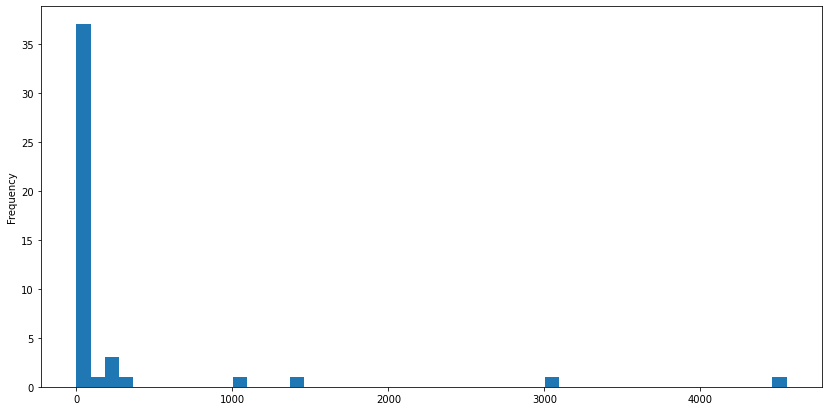

In [ ]:
raw_df_load["Parking"]=np.where(raw_df_load["Parking"].str.isdigit(),raw_df_load["Parking"],"")
raw_df_load["Parking"].value_counts().plot.hist(bins=50, figsize=(14,7));

We have 4553 missing records for parking space and few outliers which makes this field a bit unreliable. As mentioned earlier, we will drop this column since it is not much of an information given in most of the properties listed.We will also drop prop_pay_period, price_is_digit and Bedroom_is_digit left or created earlier to conclude the cleaning of our data.

In [ ]:
# Remove prop_pay_period, price_is_digit and Bedroom_is_digit column from raw_df_load
raw_df_load.drop(["prop_pay_period", "Parking", "price_is_digit", "Bedroom_is_digit", "Parking_is_digit"], axis=1, inplace=True)
raw_df_load.head()

,prop_date,prop_price_NGN,State,Area,Bedroom,Bathroom,Toilet
0,2022-08-09,300000,Ogun,Magboro,1,1,2
1,2022-08-04,900000,Lagos,Agege,3,3,3
2,2022-08-09,800000,Ogun,Arepo,3,3,4
3,2022-08-09,650000,Ogun,Arepo,2,2,3
4,2022-08-09,900000,Lagos,Isheri North,2,2,3


In [ ]:
raw_df_load.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11582 entries, 0 to 11789
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   prop_date       11582 non-null  datetime64[ns]
 1   prop_price_NGN  11582 non-null  object        
 2   State           11582 non-null  object        
 3   Area            11582 non-null  object        
 4   Bedroom         11582 non-null  object        
 5   Bathroom        11582 non-null  object        
 6   Toilet          11582 non-null  object        
dtypes: datetime64[ns](1), object(6)
memory usage: 723.9+ KB


Since we now have all our features cleaned, we would convert the relevant columns to numeric.

In [ ]:
# Convert numeric columns to numeric
raw_df_load[["prop_price_NGN", "Bedroom", "Bathroom", "Toilet"]] = raw_df_load[["prop_price_NGN", "Bedroom", "Bathroom", "Toilet"]].apply(pd.to_numeric)

In [ ]:
raw_df_load.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11582 entries, 0 to 11789
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   prop_date       11582 non-null  datetime64[ns]
 1   prop_price_NGN  11582 non-null  int64         
 2   State           11582 non-null  object        
 3   Area            11582 non-null  object        
 4   Bedroom         11582 non-null  int64         
 5   Bathroom        11582 non-null  int64         
 6   Toilet          11582 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 723.9+ KB


In [ ]:
raw_df_load.describe()

,prop_price_NGN,Bedroom,Bathroom,Toilet
count,1.158200e+04,11582.000000,11582.000000,11582.000000
mean,4.362255e+06,2.185806,2.311863,41.749266
std,3.236305e+07,1.153609,1.446736,4181.363991
min,5.500000e+04,1.000000,1.000000,1.000000
25%,1.000000e+06,1.000000,1.000000,2.000000
50%,2.000000e+06,2.000000,2.000000,3.000000
75%,4.000000e+06,3.000000,3.000000,4.000000
max,3.000000e+09,34.000000,80.000000,450000.000000


Looking at the max value, it is obvious we have some outliers in Bedroom, Bathroom and Toilet. Let's filter our dataframe to view the properties that are more than 8 rooms.

In [ ]:
display(raw_df_load.loc[(raw_df_load.Bedroom > 8)])

,prop_date,prop_price_NGN,State,Area,Bedroom,Bathroom,Toilet
735,2022-08-04,36000000,Abuja,Jahi,16,16,24
1031,2022-08-02,27000000,Lagos,Lekki,12,12,18
2621,2022-06-16,21000000,Abuja,Guzape District,18,18,24
3221,2022-01-19,250000000,Abuja,Maitama District,34,80,90
3379,2022-05-15,40000000,Abuja,Wuye,30,30,40
3693,2022-08-08,21000000,Lagos,Ikeja,18,18,24
4653,2022-07-29,65000000,Lagos,Victoria Island (VI),13,13,13
5026,2022-07-25,30000000,Lagos,Lekki,11,9,10
5978,2022-07-13,4000000,Abuja,Jahi,24,32,32
6709,2022-06-24,28000000,Abuja,Utako,24,24,32


The sort of number above is very impossible in Nigerian context. It would be difficult to see a flat or apartment with more than 8 rooms max. They are few, so, to be on the safe side, we will be doing away with values in this columns that are more than 8 for bedroom.

In [ ]:
# Drop rows from Bedroom that are greater than 8
raw_df_load.drop(raw_df_load[raw_df_load["Bedroom"] > 8].index, inplace = True)

Now, let's look at the Bathroom to display bathrooms more than 8. We will replace them with the number of bedrooms.

In [ ]:
display(raw_df_load.loc[(raw_df_load.Bathroom > 8)])

,prop_date,prop_price_NGN,State,Area,Bedroom,Bathroom,Toilet
8953,2022-05-20,2500000,Lagos,Yaba,3,33,4
9221,2022-05-04,12000000,Lagos,Ikoyi,3,32,4
9230,2022-05-04,21000000,Abuja,Guzape District,3,15,24


In [ ]:
# Replace Bathrooms that are greater than 8 with the number of bedroom
raw_df_load["Bathroom"]=np.where(raw_df_load["Bathroom"] > 8, raw_df_load["Bedroom"],raw_df_load["Bathroom"])

# Confirm with index 8953, part of the affected rows shown above
display(raw_df_load.loc[8953:8953])

,prop_date,prop_price_NGN,State,Area,Bedroom,Bathroom,Toilet
8953,2022-05-20,2500000,Lagos,Yaba,3,3,4


Finally, we will do thesame for Toilet, and replace with the number of bathroom for those greater than 8

In [ ]:
display(raw_df_load.loc[(raw_df_load.Toilet > 8)])

,prop_date,prop_price_NGN,State,Area,Bedroom,Bathroom,Toilet
854,2022-08-03,450000,Lagos,Shomolu,1,1,450000
1673,2022-07-28,900000,Lagos,Gbagada,1,1,21
3083,2022-06-21,500000,Lagos,Ikeja,1,1,12
7782,2022-07-29,2500000,Lagos,Lekki,2,2,32
7898,2022-07-24,15000000,Abuja,Asokoro District,2,2,18
9230,2022-05-04,21000000,Abuja,Guzape District,3,3,24
9450,2022-04-20,1400000,Lagos,Lekki,1,3,13


In [ ]:
# Replace Toilets that are greater than 8 with the number of bathroom
raw_df_load["Toilet"]=np.where(raw_df_load["Toilet"] > 8, raw_df_load["Bathroom"],raw_df_load["Toilet"])

# Confirm with index 8953, part of the affected rows shown above
display(raw_df_load.loc[854:854])

,prop_date,prop_price_NGN,State,Area,Bedroom,Bathroom,Toilet
854,2022-08-03,450000,Lagos,Shomolu,1,1,1


Let's check the description of our data again.

In [ ]:
raw_df_load.describe()

,prop_price_NGN,Bedroom,Bathroom,Toilet
count,1.156700e+04,11567.000000,11567.000000,11567.000000
mean,4.314912e+06,2.162186,2.277773,2.852166
std,3.228983e+07,0.905807,0.974538,1.185800
min,5.500000e+04,1.000000,1.000000,1.000000
25%,1.000000e+06,1.000000,1.000000,2.000000
50%,2.000000e+06,2.000000,2.000000,3.000000
75%,4.000000e+06,3.000000,3.000000,4.000000
max,3.000000e+09,7.000000,7.000000,8.000000


Finally! Now, we have our data cleaned. Before we go ahead with our exploratory data analysis, we would save our dataframe and load again for future use.

In [ ]:
# Save our cleaned dataframe to csv
raw_df_load.to_csv("drive/MyDrive/Data Science and ML projects/Nigerian State Relocation Guide Data/clean_property_all.csv",index=False)

## 2. Exploratory Data Analysis

Wow! 😅 We have come a long way!! We have been able to scrape our data and clean it for analysis. It is time to dig in and gain some useful insight from our data. Although, my initial plan was to look at all the States in Nigeria, but unfortunately, we could only get few States from our data. Fortunately though, we got enough data for the major cities in Nigeria. As a result of this, we would go ahead to only look at these cities, while keeping in mind as a next step in future, to look at other web platforms we could get additional data from, with other States inclusive. Bringing back our to-do EDA list, we are once again looking at:

  - The most expensive State and City in terms of apartment rent in Nigeria.
  - Maximum, Minimum, Median and Average price of rent by States.
  - Average and Median Rental Price by number of bedroom (with a focus on 1, 2, 3 and 4 bedrooms) grouped by States
  - Median Rental Price grouped by Area, identifying the most expensive place/neighbourhood in Nigeria
  - Median Rental Price by number of bedroom (with a focus on 1, 2, 3 and 4 bedrooms) grouped by Area.
  - Does time of the year have an effect on apartment rental price in Nigerian States? If so, what is the best time of the year to relocate to a particular State in Nigeria?

Let's load our data and get to work 👍

In [2]:
# Importing relevant packages for our analysis
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Loading our data and parsing date to prop_date
df_load = pd.read_csv("drive/MyDrive/Data Science and ML projects/Nigerian State Relocation Guide Data/clean_property_all.csv",
                 parse_dates=['prop_date'])
df_load.head()

,prop_date,prop_price_NGN,State,Area,Bedroom,Bathroom,Toilet
0,2022-08-09,300000,Ogun,Magboro,1,1,2
1,2022-08-04,900000,Lagos,Agege,3,3,3
2,2022-08-09,800000,Ogun,Arepo,3,3,4
3,2022-08-09,650000,Ogun,Arepo,2,2,3
4,2022-08-09,900000,Lagos,Isheri North,2,2,3


In [4]:
# Adding datetime parameters for prop_date column
df_load.sort_values(by=["prop_date"], inplace=True, ascending=True)
df_load["propYear"] = df_load.prop_date.dt.year
df_load["propMonth"] = df_load.prop_date.dt.month
df_load["propDay"] = df_load.prop_date.dt.day
df_load["propWeek"] = df_load.prop_date.dt.isocalendar().week

In [5]:
df_load.head()

,prop_date,prop_price_NGN,State,Area,Bedroom,Bathroom,Toilet,propYear,propMonth,propDay,propWeek
3379,2020-08-11,5000000,Lagos,Victoria Island (VI),3,3,4,2020,8,11,33
11161,2020-08-12,4000000,Lagos,Lekki,2,2,3,2020,8,12,33
11549,2020-08-13,2500000,Lagos,Lekki,1,1,1,2020,8,13,33
11566,2020-08-16,1700000,Lagos,Lekki,2,2,3,2020,8,16,33
11564,2020-08-17,2500000,Lagos,Lekki,2,3,3,2020,8,17,34


Now that we have enriched our dataframe with date time features, we can remove prop_date.

In [ ]:
# Copy our df dataframe into a new dataframe and drop the prop_date
df = df_load.copy()
df.drop("prop_date", axis=1, inplace=True)
df.head()

,prop_price_NGN,State,Area,Bedroom,Bathroom,Toilet,propYear,propMonth,propDay,propWeek
3379,5000000,Lagos,Victoria Island (VI),3,3,4,2020,8,11,33
11161,4000000,Lagos,Lekki,2,2,3,2020,8,12,33
11549,2500000,Lagos,Lekki,1,1,1,2020,8,13,33
11566,1700000,Lagos,Lekki,2,2,3,2020,8,16,33
11564,2500000,Lagos,Lekki,2,3,3,2020,8,17,34


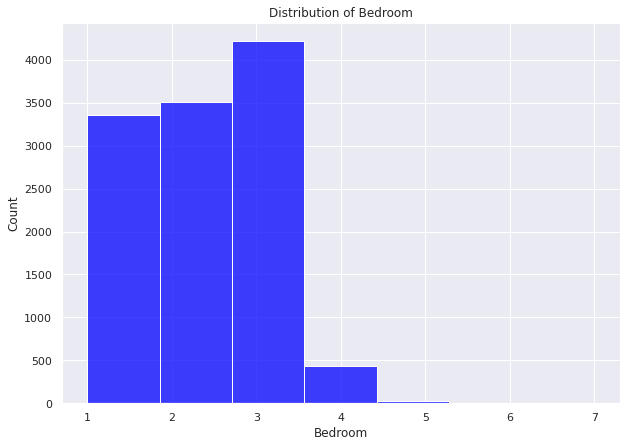

In [ ]:
# Distribution of bedroom in our dataframe
plt.figure(figsize=(10,7))
sns.histplot(df_load.Bedroom, bins=7, color='blue')
plt.title("Distribution of Bedroom");

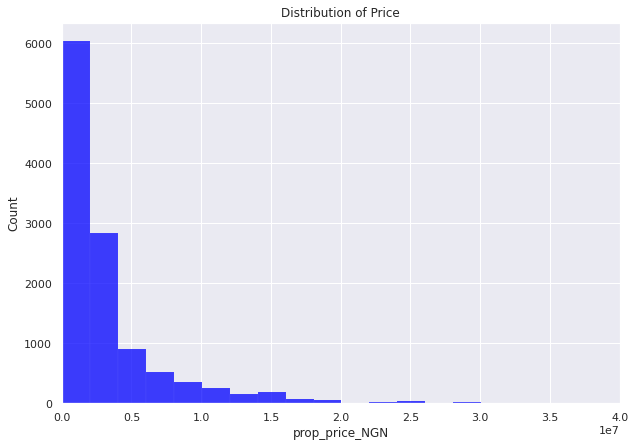

In [ ]:
# Distribution of price in our dataframe
plt.figure(figsize=(10,7))
sns.histplot(df_load.prop_price_NGN, bins=1500, color='blue')
plt.title("Distribution of Price")
plt.xlim([0,40000000]);

We are only going to be working with the major cities where we have at least more than 20 rows of data.

In [ ]:
df.State.value_counts()

Lagos        9980
Abuja        1172
Enugu         125
Rivers        117
Ogun          111
Oyo            32
Delta          23
Osun            2
Akwa Ibom       2
Edo             1
Kogi            1
Kaduna          1
Name: State, dtype: int64

To have a better representation, we would be selecting states that have more than 100 records. This leaves us with only 5 States (Lagos, Abuja, Enugu, Rivers and Ogun).

In [ ]:
# Select State that has more than 100 records
State_to_use = ["Lagos", "Abuja", "Enugu", "Rivers", "Ogun"]
df = df[df["State"].isin(State_to_use)]
df.State.value_counts()

Lagos     9980
Abuja     1172
Enugu      125
Rivers     117
Ogun       111
Name: State, dtype: int64

We have very few bedrooms within the range of 5 and 7. Let's see how many they are.

In [ ]:
df.Bedroom.value_counts()

3    4196
2    3489
1    3345
4     434
5      31
6       8
7       2
Name: Bedroom, dtype: int64

Since we do not have enough records for bedrooms between 5 and 7. We will drop them from our analysis.

In [ ]:
# Slice our dataframe to only select bedrooms from 1 - 4
df = df[df["Bedroom"]<5]

In [ ]:
df[["prop_price_NGN", "Bedroom", "Bathroom", "Toilet"]].describe()

,prop_price_NGN,Bedroom,Bathroom,Toilet
count,1.146400e+04,11464.000000,11464.000000,11464.000000
mean,4.295997e+06,2.149948,2.266312,2.840980
std,3.241244e+07,0.887025,0.959166,1.172659
min,5.500000e+04,1.000000,1.000000,1.000000
25%,1.000000e+06,1.000000,1.000000,2.000000
50%,2.000000e+06,2.000000,2.000000,3.000000
75%,4.000000e+06,3.000000,3.000000,4.000000
max,3.000000e+09,4.000000,6.000000,7.000000


In [ ]:
df.groupby("State")["prop_price_NGN"].agg([np.mean,np.median,min,max])

,mean,median,min,max
State,,,,
Abuja,3.713687e+06,2500000.0,100000,90000000
Enugu,1.394400e+06,600000.0,150000,55000000
Lagos,4.478192e+06,2000000.0,55000,3000000000
Ogun,6.118018e+05,550000.0,90000,1500000
Rivers,1.179655e+06,725000.0,140000,23800000


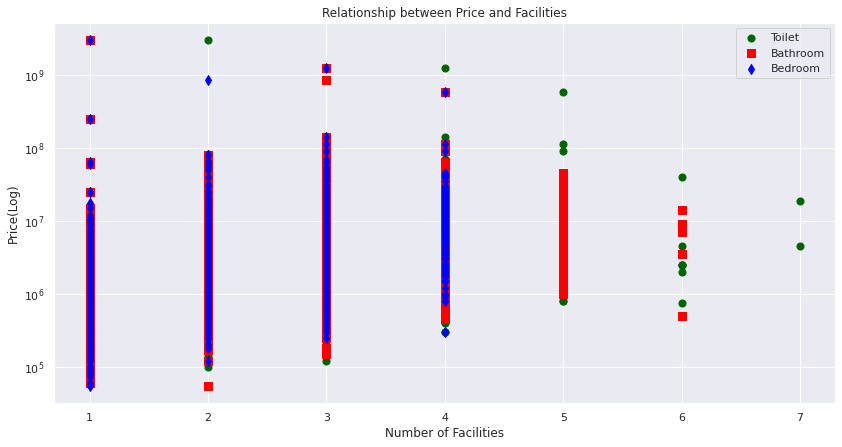

In [ ]:
# Check the relationship between price, bedroom, bathroom and toilet with scatterplot
plt.figure(figsize=(14,7))
plt.scatter(df.Toilet, df.prop_price_NGN, marker ="o", s = 50, c="DarkGreen")
plt.scatter(df.Bathroom, df.prop_price_NGN, marker ="s", s = 50, c="red")
plt.scatter(df.Bedroom, df.prop_price_NGN, marker ="d", s = 50, c="blue")
plt.yscale('log')
plt.title("Relationship between Price and Facilities")
plt.xlabel("Number of Facilities")
plt.ylabel("Price(Log)")
plt.legend(["Toilet", "Bathroom", "Bedroom"])
plt.show();

As expected, the more the number of room increases, the higher the rental value. Although, we stopped at 4 bedrooms, but some of the 4 bedrooms are known to have more than 4 toilets or bathrooms, which also affects their value, even though not significant for 6 toilets or bathrooms.

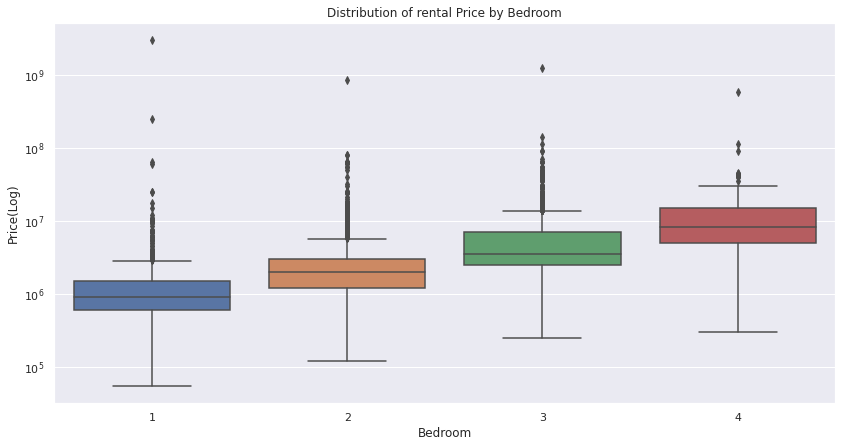

In [ ]:
# Check distribution of rental price by Bedroom
sns.boxplot(x="Bedroom", y="prop_price_NGN", data=df)
plt.yscale("log")
sns.set(rc = {'figure.figsize':(14,7)})
plt.title("Distribution of rental Price by Bedroom")
plt.xlabel("Bedroom")
plt.ylabel("Price(Log)");

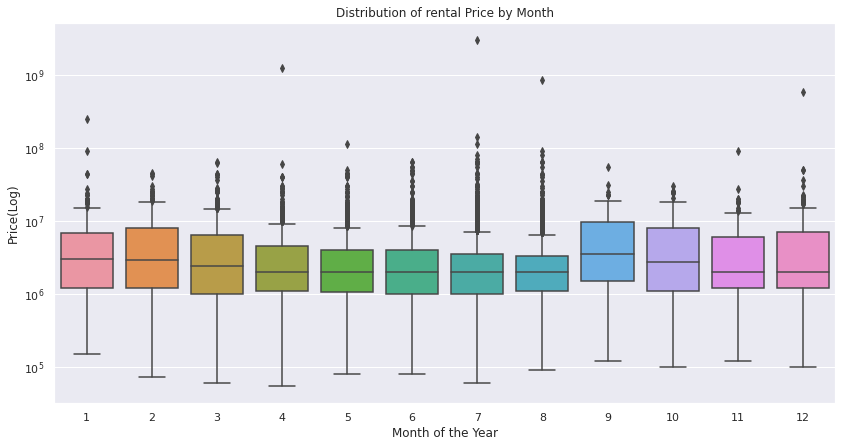

In [ ]:
# Check distribution of rental price by Month
sns.boxplot(x="propMonth", y="prop_price_NGN", data=df)
plt.yscale("log")
sns.set(rc = {'figure.figsize':(14,7)})
plt.title("Distribution of rental Price by Month")
plt.xlabel("Month of the Year")
plt.ylabel("Price(Log)");

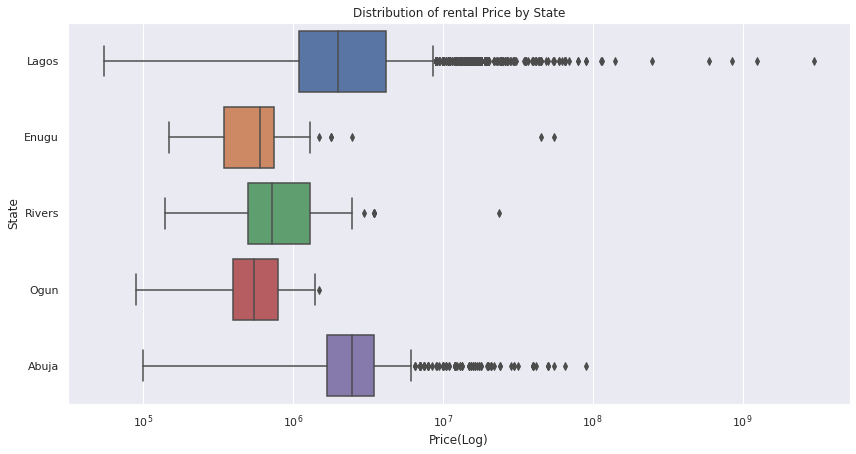

In [ ]:
# Check distribution of rental price by State
sns.boxplot(x="prop_price_NGN", y="State", data=df)
plt.xscale("log")
sns.set(rc = {'figure.figsize':(14,7)})
plt.title("Distribution of rental Price by State")
plt.xlabel("Price(Log)");

Above gives a representation of the most expensive in terms of apartment rent in Nigeria. However, we will use bar charts to show clearly the mean and median of apartment rent fees in these States, to have a better understanding of how much the average and the middle price is.

Nonetheless, according to [herefordshire UK](https://understanding.herefordshire.gov.uk/media/1389/why_do_we_use_the_median_figure_for_house_prices_and_earnings.pdf), the median is a more faithful representation of the prevalent house price than the mean, as
the latter is skewed by extreme values – you could work out a mean house price for the State, then if the next week a property costing a couple of million came on the market, the
mean price would shoot up. The median, however, would hardly be affected. Therefore, the median would be a better judge for our inference.

Based on the above, Abuja seems to be the most expensive in terms of the median price of an apartment. Let's have a better look with bar charts below.

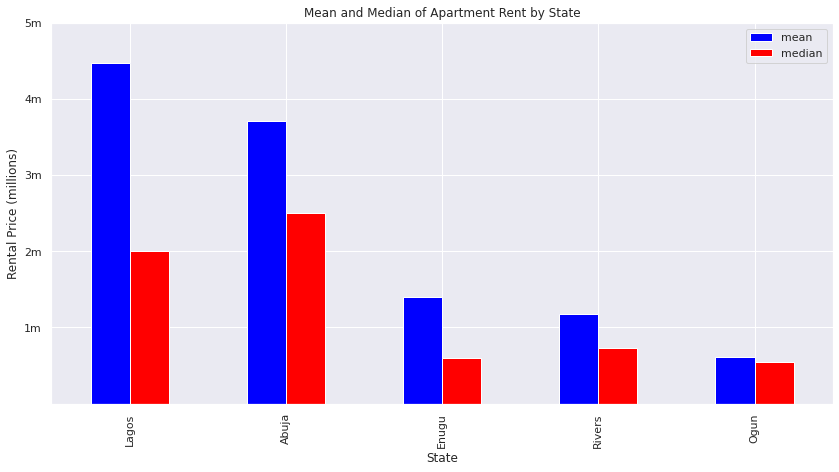

In [ ]:
# Mean and Median of Apartment Rent Price by State
df_state = df.groupby("State")["prop_price_NGN"].agg([np.mean,np.median])
df_state.sort_values(by="mean", ascending=False).plot(kind="bar", figsize=(14,7),
                                                      ylabel = "Rental Price (millions)",
                                                      title="Mean and Median of Apartment Rent by State",
                                                      color =["blue", "red"])
tick_val = [1000000, 2000000, 3000000, 4000000, 5000000]
tick_lab = ['1m', '2m', '3m', '4m', '5m']
plt.yticks(tick_val, tick_lab)
plt.show();

In [ ]:
# Define a function to plot mean and median by number of bedroom and State
def state_by_room_plot(df, column, nrooms, 
                       tick_val, 
                       tick_lab
                       ):
  '''
  Plots the mean and median based on number of rooms specified, and sorted by mean
  '''
  df_State_nroom = df[column == nrooms]
  df_State_nroom_group = df_State_nroom.groupby("State")["prop_price_NGN"].agg([np.mean,np.median])\
  .sort_values(by="mean", ascending=False)
  df_State_nroom_group.plot(kind="bar", figsize=(14,7),
                                   ylabel = "Rental Price (millions)",
                                   title=f'Mean and Median of {nrooms} Bedroom Apartment Price by State',
                                   color =["blue", "red"])
  plt.yticks(tick_val, tick_lab)
  return plt.show()

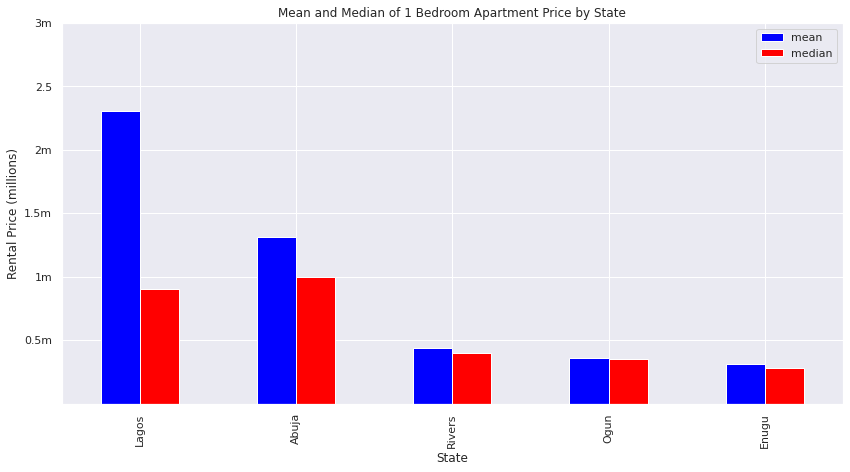

In [ ]:
# Plot mean and median of 1 bedroom apartment price by State
state_by_room_plot(df, df.Bedroom, 1, 
                   tick_val = [500000, 1000000, 1500000, 2000000, 2500000, 3000000], 
                   tick_lab = ['0.5m', '1m', '1.5m', '2m', '2.5', '3m']);

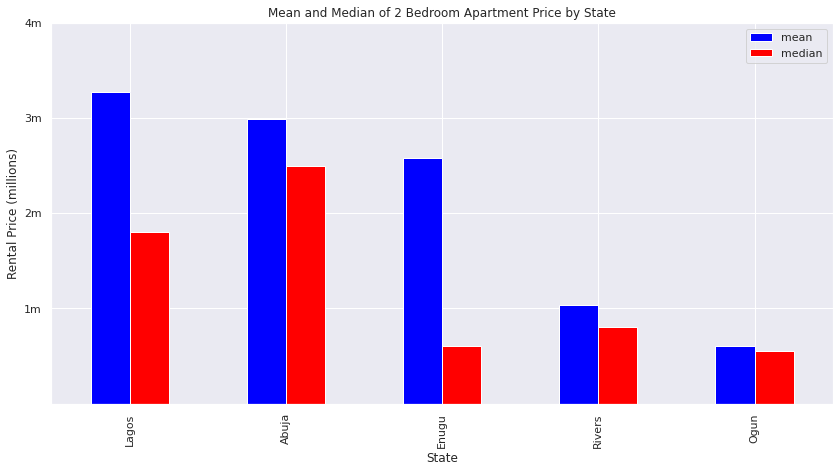

In [ ]:
# Plot mean and median of 2 bedroom apartment price by State
state_by_room_plot(df, df.Bedroom, 2, 
                   tick_val = [1000000, 2000000, 3000000, 4000000], 
                   tick_lab = ['1m', '2m', '3m', '4m']);

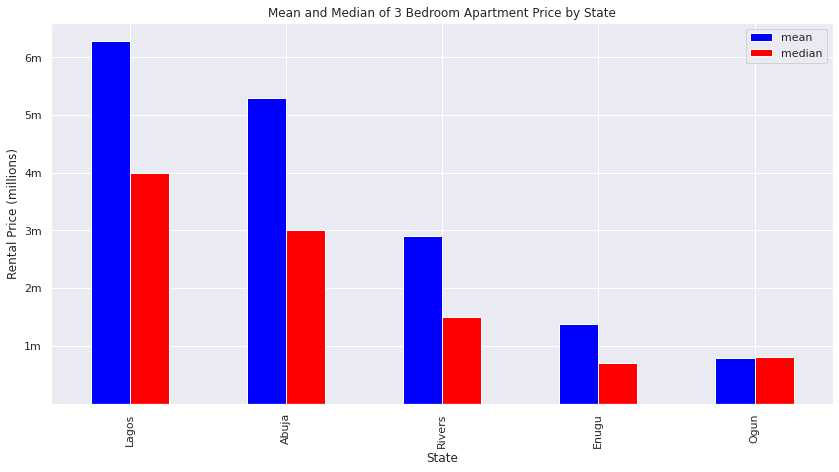

In [ ]:
# Plot mean and median of 3 bedroom apartment price by State
state_by_room_plot(df, df.Bedroom, 3, 
                   tick_val = [1000000, 2000000, 3000000, 4000000, 5000000, 6000000], 
                   tick_lab = ['1m', '2m', '3m', '4m', '5m', '6m']);

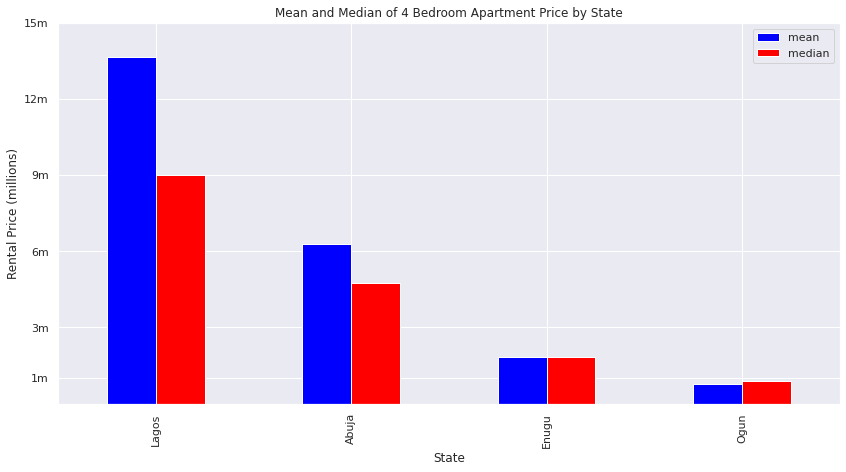

In [ ]:
# Plot mean and median of 4 bedroom apartment price by State
state_by_room_plot(df, df.Bedroom, 4, 
                   tick_val = [1000000, 3000000, 6000000, 9000000, 12000000, 15000000], 
                   tick_lab = ['1m', '3m', '6m', '9m', '12m', '15m']);

In [ ]:
# Group df by State and Area aggregated and sorted by median price
df_area = df.groupby(["State", "Area"])["prop_price_NGN"].agg([np.median])
df_area.sort_values(by="median", ascending=False, inplace=True)
df_area

median
State Area                            
Lagos Eko Atlantic City     25000000.0
Abuja Maitama District      13000000.0
Lagos Ikoyi                 11000000.0
      Victoria Island (VI)   6000000.0
Abuja Asokoro District       4500000.0
...                                ...
Ogun  Oke-Aro                 200000.0
      Ogijo                   180000.0
Abuja Nyanya                  150000.0
Lagos Badagry                 120000.0
Ogun  Sango Ota                90000.0

[98 rows x 1 columns]

Above table gives a view of the top 5 and the bottom 5 areas by median price. Let's have a better view of our findings using a bar chart.

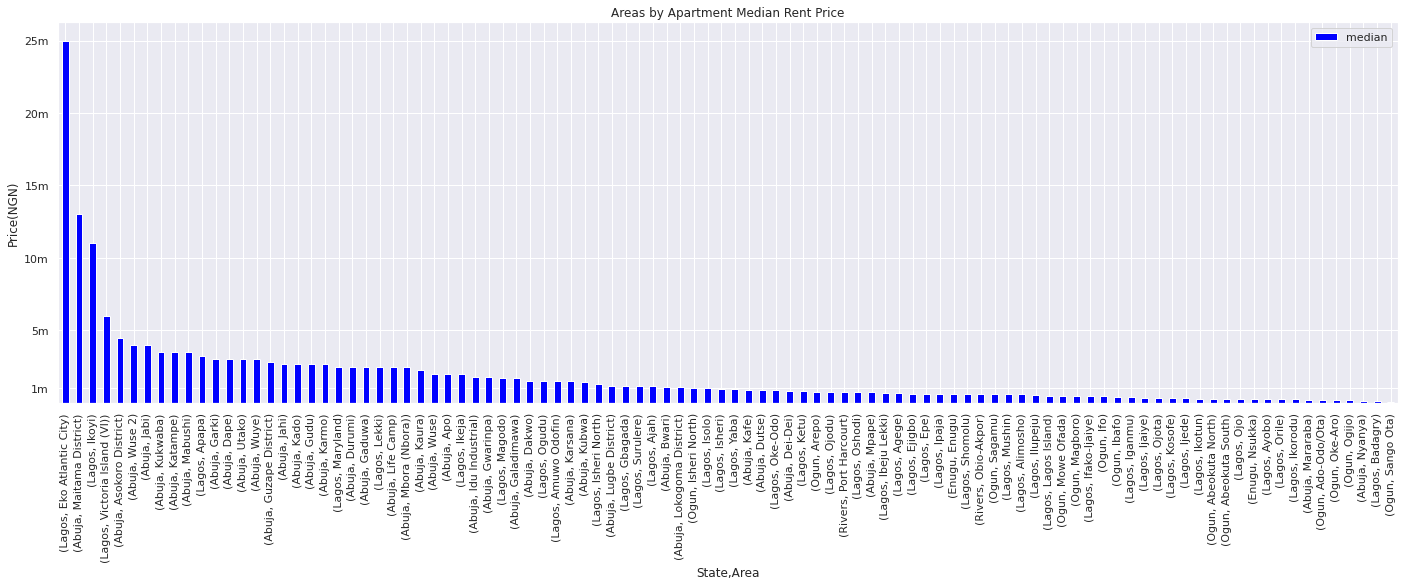

In [ ]:
# View areas in Nigeria by Median Price
df_area.plot(kind="bar", figsize=(24,7),
             ylabel = "Rental Price (millions)",
             title="Areas by Apartment Median Rent Price",
             color =["blue", "red"])
tick_val = [1000000, 5000000, 10000000, 15000000, 20000000, 25000000]
tick_lab = ['1m', '5m', '10m', '15m', '20m', '25m']
plt.yticks(tick_val, tick_lab)
plt.ylabel("Price(NGN)")
plt.show();

Above captures all the areas we have available in our data from top to bottom in terms of apartment rental price. Eko Atlantic city in Lagos is the most expensive with a median price of `NGN25m` and a very huge gap compared to the second highest, Maitama district in Abuja with a median price of `NGN13m`. Sango Ota in Ogun State has the lowest apartment rental price. However, we still need to know by number of rooms, as this could have effect on our insight, based on data available.

For our plots for areas, we are going to be using the median price instead to view the rental prices by area. Before we do this, we would define a function to plot by area and bedroom.

In [ ]:
# Define a function to plot median by number of bedroom and State
def area_by_room_plot(df, column, nrooms, tick_val, tick_lab):
  '''
  Plots the median based on number of rooms specified, and sorted by mean
  '''
  # Group df by State and Area aggregated and sorted by median price
  df_area_nroom = df[column == nrooms]
  df_area_nroom_group = df_area_nroom.groupby(["State", "Area"])["prop_price_NGN"].agg([np.median])
  df_area_nroom_group.sort_values(by="median", ascending=False, inplace=True)
  
  df_area_nroom_group.plot(kind="bar", figsize=(20,5),
                           ylabel = "Rental Price (millions)",
                           title=f'Median of {nrooms} Bedroom Apartment Price by Area',
                           color =["blue"])
  plt.yticks(tick_val, tick_lab)
  return plt.show()

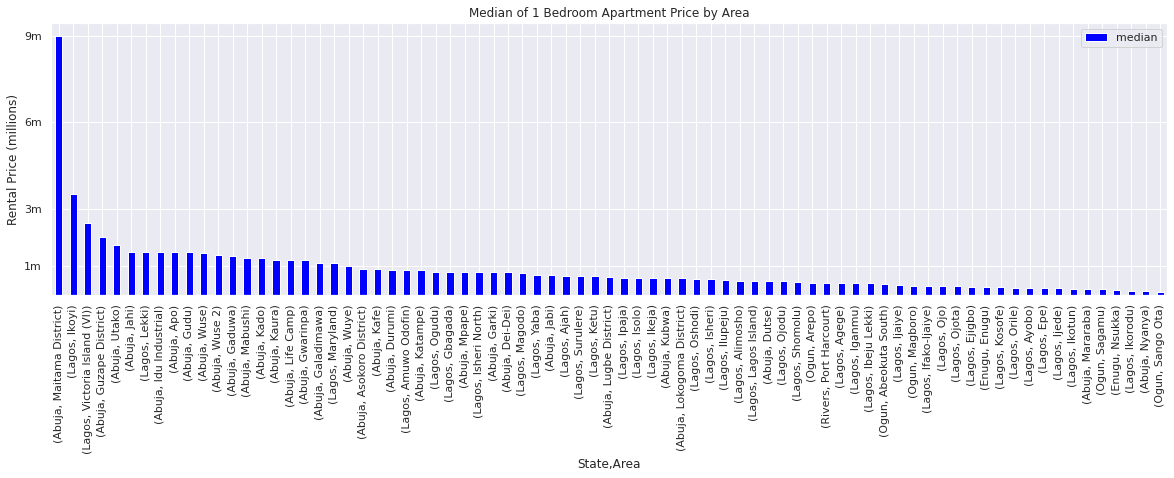

In [ ]:
# Plot median of 1 bedroom apartment price by Area
area_by_room_plot(df, df.Bedroom, 1, 
                   tick_val = [1000000, 3000000, 6000000, 9000000], 
                   tick_lab = ['1m', '3m', '6m', '9m']);

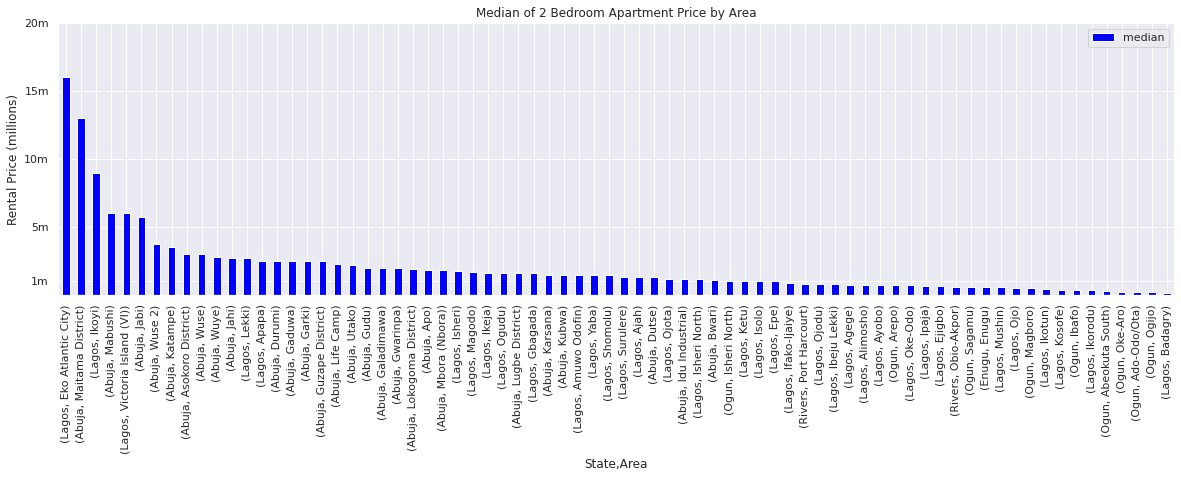

In [ ]:
# Plot median of 2 bedroom apartment price by Area
area_by_room_plot(df, df.Bedroom, 2, 
                   tick_val = [1000000, 5000000, 10000000, 15000000, 20000000], 
                   tick_lab = ['1m', '5m', '10m', '15m', '20m']);

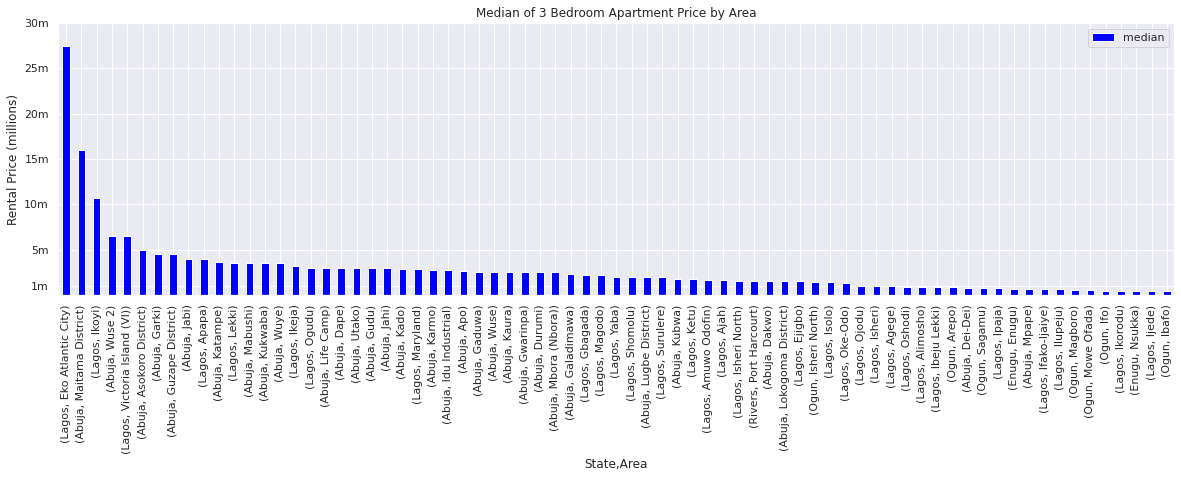

In [ ]:
# Plot median of 3 bedroom apartment price by Area
area_by_room_plot(df, df.Bedroom, 3, 
                   tick_val = [1000000, 5000000, 10000000, 15000000, 20000000, 25000000, 30000000], 
                   tick_lab = ['1m', '5m', '10m', '15m', '20m', '25m', '30m']);

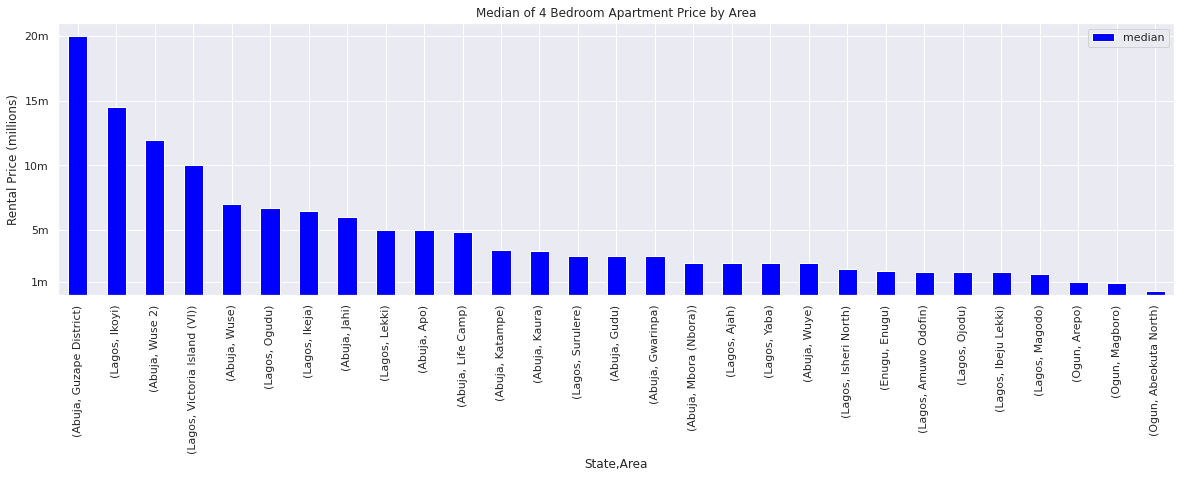

In [ ]:
# Plot median of 4 bedroom apartment price by Area
area_by_room_plot(df, df.Bedroom, 4, 
                   tick_val = [1000000, 5000000, 10000000, 15000000, 20000000], 
                   tick_lab = ['1m', '5m', '10m', '15m', '20m']);

In [ ]:
# Save our cleaned dataframe to csv to enable us load for prediction without rerunning eda
df_load.to_csv("drive/MyDrive/Data Science and ML projects/Nigerian State Relocation Guide Data/clean_property_with_dt.csv",index=False)

## 3. Predicting the price of an apartment

In [127]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

# Make NumPy printouts easier to read
np.set_printoptions(precision=3, suppress=True)
sns.set()

In [128]:
df_for_pred = pd.read_csv("drive/MyDrive/Data Science and ML projects/Nigerian State Relocation Guide Data/clean_property_with_dt.csv",
                 #parse_dates=['prop_date'],
                 usecols = ['State','Area','Bedroom','Bathroom','Toilet','prop_price_NGN'])

### Preprocessing our data

In [129]:
# View our data
df_for_pred.head()

,prop_price_NGN,State,Area,Bedroom,Bathroom,Toilet
0,5000000,Lagos,Victoria Island (VI),3,3,4
1,4000000,Lagos,Lekki,2,2,3
2,2500000,Lagos,Lekki,1,1,1
3,1700000,Lagos,Lekki,2,2,3
4,2500000,Lagos,Lekki,2,3,3


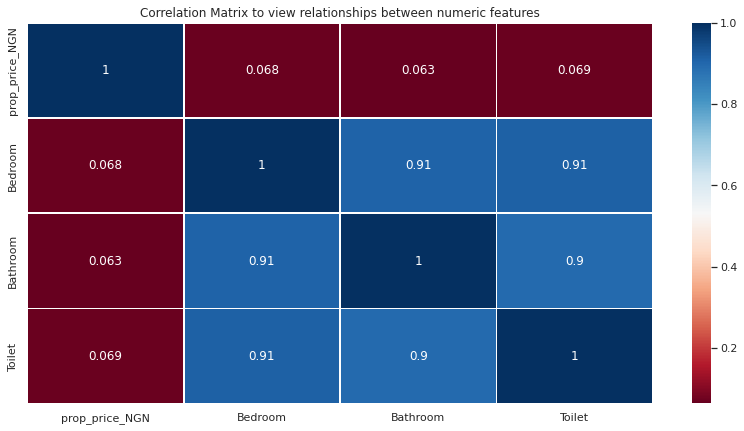

In [130]:
# Make a correlation matrix
corr_matrix = df_for_pred.corr()
fig,ax = plt.subplots(figsize=(14,7))
plt.title("Correlation Matrix to view relationships between numeric features")
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 cmap='RdBu');

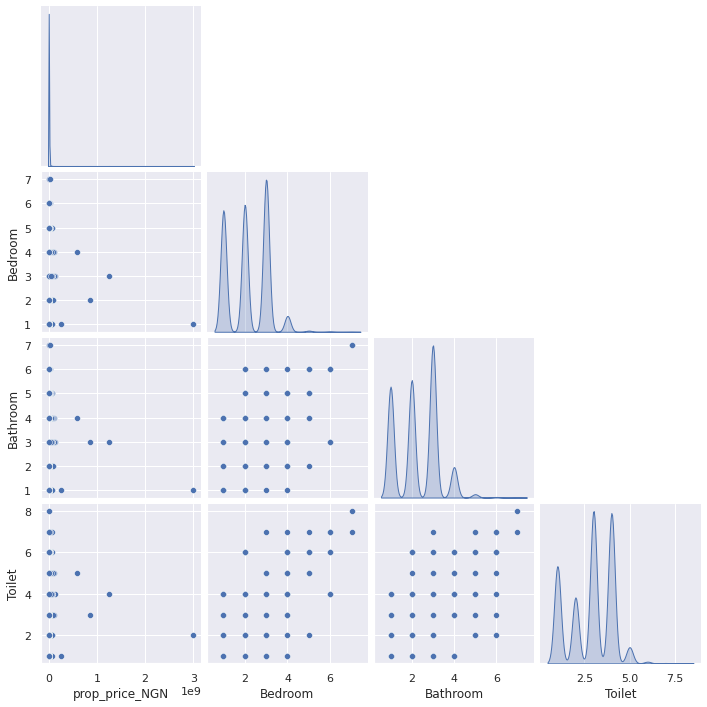

In [131]:
sns.pairplot(df_for_pred, diag_kind='kde', corner=True);

In [132]:
df_for_pred.dtypes

prop_price_NGN     int64
State             object
Area              object
Bedroom            int64
Bathroom           int64
Toilet             int64
dtype: object

In [133]:
dataset = pd.get_dummies(df_for_pred, columns=['State', 'Area'], prefix='', prefix_sep='')
dataset.tail()

,prop_price_NGN,Bedroom,Bathroom,Toilet,Abuja,Akwa Ibom,Delta,Edo,Enugu,Kaduna,...,Shomolu,Surulere,Utako,Uyo,Victoria Island (VI),Warri,Wuse,Wuse 2,Wuye,Yaba
11562,5000000,2,3,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11563,850000,2,2,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11564,600000,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11565,1800000,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11566,300000,1,1,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Experimenting with Different Models
To make our experimentation cleaner and easy for us to find the best model, we will be writing few lines of code to iterate the process, and sort by the best model. This way, we can focus on tuning the parameters of the best model for use.

In [134]:
def best_reg_model(X_train,y_train,X_test,y_test):
  from sklearn.metrics import r2_score
  from sklearn.metrics import mean_squared_error
  # Import our models for regression
  from sklearn.linear_model import LinearRegression
  from sklearn.linear_model import Ridge
  from sklearn.linear_model import ElasticNet
  from sklearn.linear_model import BayesianRidge
  from sklearn.linear_model import ARDRegression
  from sklearn.svm import SVR
  from sklearn.svm import NuSVR
  from sklearn.svm import LinearSVR
  from sklearn.ensemble import BaggingRegressor
  from sklearn.ensemble import RandomForestRegressor
  from sklearn.ensemble import ExtraTreesRegressor
  from sklearn.ensemble import AdaBoostRegressor
  from sklearn.ensemble import HistGradientBoostingRegressor
  from sklearn.ensemble import GradientBoostingRegressor

  # Put our regression models in two-dimensional list
  models = [
      ["LinearRegression", LinearRegression],
      ["Ridge", Ridge],
      ["ElasticNet", ElasticNet],
      ["BayesianRidge", BayesianRidge],
      ["ARD", ARDRegression],
      ["SVR", SVR],
      ["NuSVR", NuSVR],
      ["LinearSVR", LinearSVR],
      ["BaggingRegressor", BaggingRegressor],
      ["RandomForestRegressor", RandomForestRegressor],
      ["ExtraTreesRegressor", ExtraTreesRegressor],
      ["AdaBoostRegressor", AdaBoostRegressor],
      ["HistGradientBoostingRegressor", HistGradientBoostingRegressor],
      ["GradientBoostingRegressor", GradientBoostingRegressor]
  ]

  # Use a Nested loop through each algorithm and append each model and score to insight
  insights = []
  for modelname, Model in models:
      model = Model()
      model.fit(X_train, y_train)
      train_preds = model.predict(X_train)
      test_preds = model.predict(X_test)
      train_score = r2_score(y_train, train_preds)
      test_score = r2_score(y_test, test_preds)
      #score2 = mean_squared_error(y_true = y_test, y_pred = y_preds)
      #score = model.score(X_test, y_test)
      insights.append((modelname, np.around(test_score,5), np.around(train_score,5)))

  # Sort to get the top 5 performing model-parameter pair and plot
  insights = pd.DataFrame(insights, columns=['Model','Test score','Train score'])
  insights = insights.sort_values(['Test score'], ascending=False).reset_index(drop=True)
  return insights[:5]

In [141]:
train_dataset = dataset.sample(frac=0.8, random_state=13)
test_dataset = dataset.drop(train_dataset.index)

X_train = train_dataset.drop("prop_price_NGN", axis=1)
X_test = test_dataset.drop("prop_price_NGN", axis=1)

y_train = train_dataset["prop_price_NGN"]
y_test = test_dataset["prop_price_NGN"]

In [142]:
%%time
best_reg_model(X_train,y_train,X_test,y_test)

CPU times: user 1min 7s, sys: 928 ms, total: 1min 8s
Wall time: 1min 13s


,Model,Test score,Train score
0,Ridge,0.47532,0.01109
1,GradientBoostingRegressor,0.40394,0.01714
2,RandomForestRegressor,0.30083,0.01918
3,ElasticNet,0.25157,0.00542
4,AdaBoostRegressor,0.24850,0.00773


Our model has performed poorly on both training and test set. Ridge regressor and GradientBoostingRegressor seems like the only models that performed fairly here on the testing data but poorly on the training set with the assumption of an underfitting. Probably we can have a better score, if we tune the hyper parameters. Ideally, the closer to 1, the better. One could assume the possibility that we have a very small test set and by chance our model accidentally does unexpectedly well on it! This result shows we might need more data to be able to build our prediction model.

Nonetheless, for experimentation purposes, I will try to convert the strings to categorical and use the coding method for the categories to see if we would have a better score.

In [143]:
# Copy the dataset into a new one
dataset2 = df_for_pred.copy()
dataset2.head()

,prop_price_NGN,State,Area,Bedroom,Bathroom,Toilet
0,5000000,Lagos,Victoria Island (VI),3,3,4
1,4000000,Lagos,Lekki,2,2,3
2,2500000,Lagos,Lekki,1,1,1
3,1700000,Lagos,Lekki,2,2,3
4,2500000,Lagos,Lekki,2,3,3


In [144]:
# Find the columns which contain strings
for label, content in dataset2.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

State
Area


In [145]:
# Turn all string value into category values
for label, content in dataset2.items():
    if pd.api.types.is_string_dtype(content):
        dataset2[label] = content.astype('category').cat.as_ordered()

Now, under the hood, pandas will treat our categories as code, instead of strings, since we have converted them to category. Let's look at one of the column; state.

In [146]:
dataset2.State.cat.codes.head(5)

0    7
1    7
2    7
3    7
4    7
dtype: int8

Above shows that for all the strings (unique) in each of the columns with labels, which we have specified, pandas has assigned a code to each of them, which we would use for our machine learning model. However, we still have a lot of missing data, which we would look at next. Once again, let's look at the percentage of missing data in each of our column.

In [147]:
# Turn categorical variables into numbers
for label, content in dataset2.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Turn categories into numbers and add +1
        dataset2[label] = pd.Categorical(content).codes+1

In [148]:
# Check for columns which aren't numeric and have null values
for label, content in dataset2.items():
    if not pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

In [149]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11567 entries, 0 to 11566
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   prop_price_NGN  11567 non-null  int64
 1   State           11567 non-null  int8 
 2   Area            11567 non-null  int8 
 3   Bedroom         11567 non-null  int64
 4   Bathroom        11567 non-null  int64
 5   Toilet          11567 non-null  int64
dtypes: int64(4), int8(2)
memory usage: 384.2 KB


In [150]:
#Split our dataset2 data using thesame random_state
train_dataset2 = dataset2.sample(frac=0.8, random_state=13)
test_dataset2 = dataset2.drop(train_dataset2.index)

X_train2 = train_dataset2.drop("prop_price_NGN", axis=1)
X_test2 = test_dataset2.drop("prop_price_NGN", axis=1)

y_train2 = train_dataset2["prop_price_NGN"]
y_test2 = test_dataset2["prop_price_NGN"]

In [151]:
%%time
best_reg_model(X_train2,y_train2,X_test2,y_test2)

CPU times: user 25.6 s, sys: 423 ms, total: 26 s
Wall time: 25.1 s


,Model,Test score,Train score
0,GradientBoostingRegressor,0.37702,0.01512
1,BaggingRegressor,0.32212,0.01870
2,AdaBoostRegressor,0.29078,0.00854
3,HistGradientBoostingRegressor,0.22358,0.01795
4,RandomForestRegressor,0.21545,0.01913


We do not seem to have any chance with this data for predictive modelling. Test Score and Train score for all our top models are nothing close to substantial for progressing with our experimentation. 

Although, since `GradientBoostingRegressor` seems to have been fair both ways on the test score, let's still try to do some hyperparameter tuning, to see if we can get it to be better for future reference.

### Hyperparameter Tuning with RandomizedSearchCV

In [153]:
# View the hyperparameters in GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor()
model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [154]:
# Define our different GradientBoostingRegressor hyperparameters
gbr_grid = {'n_estimators': np.arange(10, 200, 10),
            'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'],
            'learning_rate': np.arange(0.1, 2.0, 0.2),
            'subsample' : np.arange(0.1, 1.0, 0.2),
            'criterion': ['friedman_mse', 'squared_error'],
            'max_depth': [None, 3, 5, 10],
            'min_samples_split': np.arange(2, 20, 2),
            'min_samples_leaf': np.arange(1, 20, 2),
            'min_weight_fraction_leaf': np.arange(0.1, 0.5, 0.1), 
            'max_features': [0.5, 1, 'sqrt', 'auto', 'log2', None],
            'alpha': np.arange(0.1, 1.0, 0.2),
            'max_leaf_nodes': np.arange(2, 20, 2),
            'validation_fraction': np.arange(0.1, 1.0, 0.2),
            'ccp_alpha': np.arange(0.1, 2.0, 0.2)}

Let's also create an evaluation function for our model.

In [155]:
# Create evaluation function
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    '''
    calculate root mean squared log error between predictions and true labels.
    '''
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model,X_train,y_train,X_test,y_test):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    scores = {'Training MAE': mean_absolute_error(y_train, train_preds),
              'Test MAE': mean_absolute_error(y_test, test_preds),
              #'Training RMSLE': rmsle(y_train, train_preds),
              #'Test RMSLE': rmsle(y_test, test_preds),
              'Training R^2': r2_score(y_train, train_preds),
              'Test R^2': r2_score(y_test, test_preds),}
    return scores

### Implementing our RandomizedSearchCV

In [ ]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(GradientBoostingRegressor(random_state=42),
                              param_distributions=gbr_grid,
                              n_iter=100,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 3min 55s, sys: 507 ms, total: 3min 55s
Wall time: 3min 55s


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=100,
                   param_distributions={'alpha': array([0.1, 0.3, 0.5, 0.7, 0.9]),
                                        'ccp_alpha': array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]),
                                        'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'learning_rate': array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]),
                                        'loss': ['squared_error',
                                                 'absolute...
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'min_weight_fraction_leaf': array([0.1, 0.2, 0.3, 0.4]

In [ ]:
show_scores(rs_model, X_train, y_train, X_test, y_test)

{'Training MAE': 2335647.8081147224,
 'Test MAE': 1502626.2890828708,
 'Training R^2': 0.006578392595341542,
 'Test R^2': 0.4119374351737424}

In [ ]:
%%time
# Instantiate RandomizedSearchCV model on the second coded dataset
rs_model2 = RandomizedSearchCV(GradientBoostingRegressor(random_state=42),
                              param_distributions=gbr_grid,
                              n_iter=100,
                              cv=5,
                              verbose=True)

# Fit the RandomizedSearchCV model on X2
rs_model2.fit(X_train2, y_train2)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 2min 20s, sys: 370 ms, total: 2min 20s
Wall time: 2min 20s


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=100,
                   param_distributions={'alpha': array([0.1, 0.3, 0.5, 0.7, 0.9]),
                                        'ccp_alpha': array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]),
                                        'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'learning_rate': array([0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9]),
                                        'loss': ['squared_error',
                                                 'absolute...
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'min_weight_fraction_leaf': array([0.1, 0.2, 0.3, 0.4]

In [ ]:
show_scores(rs_model2, X_train2, y_train2, X_test2, y_test2)

{'Training MAE': 2240293.8373420374,
 'Test MAE': 1434244.1875516414,
 'Training R^2': 0.006953477571778999,
 'Test R^2': 0.42838803063955233}

We definitely need additional data to get our model to predict well on both training and testing data. This was expected as we do not have enough sample for some areas in the States enough to be representative for our prediction. For now, after searching through different regression models, and tuning the hyperparameters, our model still is not capable of predicting accurately.

### Next Steps on Price Prediction:
- Collect more data to build our model for price prediction
- Get extra features that may be useful for accurate prediction. Unfortunately, we do not have enough features to extract from the website we scraped our data.

## 4. Building a Custom Search Function

In [2]:
# Load our dataset
import pandas as pd
cols = ['State','Area','Bedroom','Bathroom','prop_price_NGN']
df_for_rec = pd.read_csv("drive/MyDrive/Data Science and ML projects/Nigerian State Relocation Guide Data/clean_property_with_dt.csv",
                 usecols = cols)
df_for_rec = df_for_rec[cols]
df_for_rec

,State,Area,Bedroom,Bathroom,prop_price_NGN
0,Lagos,Victoria Island (VI),3,3,5000000
1,Lagos,Lekki,2,2,4000000
2,Lagos,Lekki,1,1,2500000
3,Lagos,Lekki,2,2,1700000
4,Lagos,Lekki,2,3,2500000
...,...,...,...,...,...
11562,Lagos,Lekki,2,3,5000000
11563,Lagos,Ajah,2,2,850000
11564,Abuja,Kubwa,1,1,600000
11565,Lagos,Lekki,1,1,1800000


In [3]:
df_for_rec.describe()

,Bedroom,Bathroom,prop_price_NGN
count,11567.000000,11567.000000,1.156700e+04
mean,2.162186,2.277773,4.314912e+06
std,0.905807,0.974538,3.228983e+07
min,1.000000,1.000000,5.500000e+04
25%,1.000000,1.000000,1.000000e+06
50%,2.000000,2.000000,2.000000e+06
75%,3.000000,3.000000,4.000000e+06
max,7.000000,7.000000,3.000000e+09


To build our engine, we will group our data by State, Area, Bedroom, Bathroom and Toilet, returning the median price of each unique group. We will be using Median Price, to help prevent exaggerated figures of an apartment as a result of outliers.

In [44]:
df_rec_grp = df_for_rec.groupby(['State', 'Area', 'Bedroom', 'Bathroom'], as_index=False).median()
df_rec_grp.rename(columns = {'prop_price_NGN':'Median_Rent_NGN'}, inplace = True)
df_rec_grp["Median_Rent_NGN"] = df_rec_grp["Median_Rent_NGN"].astype(int)
df_rec_grp

,State,Area,Bedroom,Bathroom,Median_Rent_NGN
0,Abuja,Apo,1,1,1325000
1,Abuja,Apo,1,2,1500000
2,Abuja,Apo,2,2,1800000
3,Abuja,Apo,2,3,1500000
4,Abuja,Apo,3,3,2200000
...,...,...,...,...,...
515,Rivers,Port Harcourt,2,3,750000
516,Rivers,Port Harcourt,2,6,500000
517,Rivers,Port Harcourt,3,3,1500000
518,Rivers,Port Harcourt,3,4,1200000


In [45]:
# Write a filter function to search based on criteria
def search(State, Bedroom, budget, top_n=10):
  results_State = df_rec_grp[df_rec_grp["State"] == State]
  results_Bedroom =  results_State[results_State["Bedroom"] == Bedroom]
  min_budget = budget * 0.8
  results_rent = results_Bedroom[(results_Bedroom['Median_Rent_NGN'] >= min_budget) & (results_Bedroom['Median_Rent_NGN'] <= budget)]
  results = results_rent.sort_values(['Median_Rent_NGN'], ascending=False).reset_index(drop=True)
  results = results[:top_n]
    
  return results

In [60]:
search("Abuja", 2, 1500000, 7)

,State,Area,Bedroom,Bathroom,Median_Rent_NGN
0,Abuja,Apo,2,3,1500000
1,Abuja,Gwarinpa,2,1,1500000
2,Abuja,Karsana,2,2,1500000
3,Abuja,Kubwa,2,2,1500000
4,Abuja,Kubwa,2,3,1500000
5,Abuja,Lugbe District,2,3,1500000
6,Abuja,Dutse,2,2,1300000


In [73]:
# Define an interactive function to find an apartment
def find_an_apartment():
  State = input('What State are you relocating to?\n')
  print("\n")
  Bedroom = int(input('How many bedroom are you looking at?\n'))
  print("\n")
  budget = int(input('What is your budget (no comma)?\n'))
  print("\n")
  top_n = int(input('Number of results to view\n'))
  print("\n")

  apartment_rec = search(State, Bedroom, budget, top_n)
  print('Recommending Areas to you based on your budget...')
  print("\n")
  print('\033[1mSee below the list of places you can stay based on your budget\033[0m')
  return apartment_rec

In [75]:
find_an_apartment()

What State are you relocating to?
Abuja


How many bedroom are you looking at?
2


What is your budget (no comma)?
1500000


Number of results to view
15


Recommending Areas to you based on your budget...


See below the list of places you can stay based on your budget


,State,Area,Bedroom,Bathroom,Median_Rent_NGN
0,Abuja,Apo,2,3,1500000
1,Abuja,Gwarinpa,2,1,1500000
2,Abuja,Karsana,2,2,1500000
3,Abuja,Kubwa,2,2,1500000
4,Abuja,Kubwa,2,3,1500000
5,Abuja,Lugbe District,2,3,1500000
6,Abuja,Dutse,2,2,1300000
7,Abuja,Idu Industrial,2,3,1200000
8,Abuja,Lugbe District,2,1,1200000
